---

<div align=center>

# 📜 **Abstract**

</div>

Nulling interferometry $^1$ is a promising technique for direct detection of exoplanets. However, the performance of current devices is limited by the sensitivity to any phase aberrations. The work presented here attempts to overcome those limitations by using a four-telescopes nulling interferometer architecture, called Kernel-Nuller $^2$, which includes a recombiner that positions the four signals in phase quadrature. This architecture is based on an integrated optical component containing 14 electronically controlled phase shifters, used to correct optical path differences that would be induced by manufacturing defects. The first part of the study consists in the development of an algorithm providing the delays to be injected into the component to optimize the performance of that device. The next step of this study deals with the analysis of the intensity distributions produced at the output of the Kernel-Nuller $^{2,3}$ through a series of observations, and then apply statistical tests and data treatment techniques to detect the presence of exoplanets.

> **References**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9
> 2. Martinache, F., Ireland, M.J., 2018. Kernel-nulling for a robust direct interferometric detection of extrasolar planets. A&A 619, A87. https://doi.org/10.1051/0004-6361/201832847
> 3. Cvetojevic, N. et al., 2022. 3-beam self-calibrated Kernel nulling photonic interferometer. arXiv e-prints. https://doi.org/10.48550/arXiv.2206.04977


---

<div align=center>

# **🖥️ Simulation requirements**

</div>

## 📥 Imports

In [1]:
import os
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
from IPython.display import clear_output, display
import sympy as sp
import fitter
import numba as nb
from scipy.optimize import curve_fit
from scipy.ndimage import rotate
from LRFutils import color
import tensorflow as tf

## 🎛️ Parameters

<div align=center>
👉 <i><U>Only edit the following block</u></i>
</div>

In [2]:
# Wavelength
L = 1.65 * u.um

# Telescopes properties
TELESCOPE_POSITIONS = np.array([
    [0, 0],
    [1, 1],
    [2, 1.5],
    [3, 0.7],
]) * 42.2 * u.m
LATITUDE = -24.6275 * u.deg
DECLINATION = -64.71 * u.deg
FOV = 10 * u.mas # Field of view

# Observation conditions
STAR_MAGNITUDE = 0 * u.mag
SPECTRAL_WIDTH = 0.3 * u.um
OPTICAL_EFFICIENCY = 0.01
DH = 8 * u.hourangle # Observation duration
DT = 1 * u.s # Exposure time

# Companions properties
COMPANIONS = [
    {'contrast':1e-3, 'angular_separation':5.23 * u.mas, 'parallactic_angle':49.68 * u.deg},
    {'contrast':1e-3, 'angular_separation':7 * u.mas, 'parallactic_angle':-25 * u.deg},
    {'contrast':1e-3, 'angular_separation':3 * u.mas, 'parallactic_angle':141 * u.deg},
]

# Cophasing errors
INPUT_CE_RMS = 10 * u.nm # ~100 nm for ground based telescopes, 10 to 1 nm for space telescopes
SHIFTS_CE_RMS = 10 * u.nm
SHIFTS_CE_OFFSET = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) * u.nm

# SHIFTS_CE_OFFSET = np.array([1.64214688, 1.64216085, 0.00554631, 1.64884721, 1.62784278, 0.03160111, 0.0182902, 0.02791266, 0.01329669, 0.01020052, 1.63187602, 1.64524911, 0.02049508, 0.0165746]) * L.unit
# SHIFTS_CE_RMS = L*0

Processing parameters (conversion to commonly used units)

In [3]:
TELESCOPE_POSITIONS = TELESCOPE_POSITIONS.to(u.m)
LATITUDE = LATITUDE.to(u.deg)
DECLINATION = DECLINATION.to(u.deg)
INPUT_CE_RMS = INPUT_CE_RMS.to(L.unit)
SHIFTS_CE_RMS = SHIFTS_CE_RMS.to(L.unit)
SHIFTS_CE_OFFSET = SHIFTS_CE_OFFSET.to(L.unit)
PARALLACTIC_ANGLE_RANGE = np.linspace(0,2*np.pi,360)*u.rad
EXTENT = (-FOV.value, FOV.value, -FOV.value, FOV.value)
H_RANGE = np.linspace(-DH/2, DH/2, 100)
FOV = FOV.to(u.mas)
for companion in COMPANIONS:
    companion['angular_separation'] = companion['angular_separation'].to(u.mas)
    companion['parallactic_angle'] = companion['parallactic_angle'].to(u.rad)
π = np.pi

## 🔧 Utils

We only consider relative phases, so we only consider phase shift in `[0,wavelenght[`

In [4]:
def bound_phase(δφ:u.Quantity, λ:u.Quantity=L) -> u.Quantity:
    """Bring a phase to the interval [0, wavelenght[.

    Parameters
    ----------
    - δφ: Phase to bound (any distance unit)
    - λ: Wavelenght of the light (any distance unit)

    Returns
    -------
    - Phase in the interval [0, wavelenght]
    """
    return bound_phase_njit(δφ.value, λ.to(δφ.unit).value) * δφ.unit

@nb.njit()
def bound_phase_njit(
        δφ:float,
        λ:float=L.value,
    ) -> float:
    """Bring a phase to the interval [0, wavelenght[.

    Parameters
    ----------
    - δφ: Phase to bound (in distance unit)
    - λ: Wavelenght of the light (same unit as phase) 

    Returns
    -------
    - Phase in the interval [0, wavelenght]
    """
    return np.mod(δφ, λ)

---

<div align=center>

# 🤔 **Context**

</div>

## 🎯 Goal

We aim to detect make direct detection of exoplanets. There is two main challenges to achieve this goal:
- The **contrast**: the exoplanet is much fainter than the star it orbits. The contrast is typically of the order of $10^{-6}$ to $10^{-10}$.
- The **angular separation**: the exoplanet is very close to the star. The angular separation depend on the distance of the exoplanet to the star and the distance of the star to the observer and can easily goes below the arcsecond.

## 🔎 Detection methods

It exist several methods to detect exoplanets. The most common are:
- **Radial velocity method**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the Doppler effect (the light is alternatively redshifted and blueshifted).
- **Transit method**: the exoplanet pass in front of the star and block a fraction of the light. This fraction can be detected by the decrease of the star luminosity.
- **Microlensing**: the exoplanet act as a lens and magnify the light of a background star. This magnification can be detected by the increase of the star luminosity.
- **Astrometry**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the change of the star position.
- **Coronography**: the exoplanet is directly imaged. This is the most challenging method because of the contrast and the angular separation.

<div align=center>
<img src="img/detection_methods.jpg" width=500px>
<p><i>Paul Anthony Wilson - Exoplanet detection techniques</i><p>
</div>

Until now, the coronography was the only method allowing direct detection. But it has two main limitations:
- It require huge telescopes in order to have a good angular resolution.
- The contrast we can achieve is limited by unperfect fabrication process of the optical components which lead to undesired diffraction effects.

## ➖ Nulling

This is where the Nulling technic $^1$ come into play. The idea is to use two several telescopes and take advantage of destructives interferances to cancel the star light and using the fact that the planet is not perfectly in the line of sight, which will lead to an unperfect destructive interference, or in best scenarios, on constructive ones! This is a very challenging technic because it is highly phase sensitive and require a very good control of the optical path.

<div align=center>
<img src="img/nulling_principle.jpg" width=500px>
</div>

In a perfect 2-telescope nulling system, we can express the two acquired electric field (cf. section "Signal nature" below) in a vector:

$$
E = \begin{pmatrix}
E_1 \\
E_2
\end{pmatrix}
$$

And then express the nulling operation using the following matrix:

$$
N = \begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}
$$

Such as it gives us two outputs with a constructive and a destructive interference (we will focus on the latter):

$$
N \cdot E = \begin{pmatrix}
E_1 + E_2 \\
E_1 - E_2
\end{pmatrix}
$$

> **References**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9

In [5]:
# 2x2 nuller

@nb.njit()
def nuller_2x2(beams:np.ndarray[complex]) -> np.ndarray[complex]:
    """
    Simulate a 2 input beam nuller.

    Parameters
    ----------
    - beams: Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
        - 1st output is the bright channel
        - 2nd output is the dark channel
    """

    # Nuller matrix
    N = 1/np.sqrt(2) * np.array([
        [1,   1],
        [1,  -1],
    ], dtype=np.complex128)

    # Operation
    return N @ beams

## 📡 Projected telescope position

The interferometry process depend on the projected geometry of the telescope position in the plane perpendicular to the line of sight. For each observation, we will then need to compute these projected positions in order to have the correct baseline lenght (and thus the correct phase shifts).\
These projected location can be computed using the following formula $^{1,2}$:

$$
\begin{pmatrix}
u \\
v
\end{pmatrix} =
\begin{pmatrix}
- \sin(l) \sin(h) & \cos(h)\\
\sin(l) \cos(h) \sin(\delta) + \cos(l) \cos(\delta) & \sin(h) \sin(\delta)
\end{pmatrix}
\begin{pmatrix}
B_\text{north} \\
B_\text{east}
\end{pmatrix}
$$

with
- $l$ the latitude of the observatory
- $h$ the hour angle
- $\delta$ the declination of the star

> *Rerefence*
> 1. Chingaipe, P.M. et al., 2023. High-contrast detection of exoplanets with a kernel-nuller at the VLTI. A&A 676, A43. https://doi.org/10.1051/0004-6361/202346118
> 2. Ségransan, D., 2007. Observability and UV coverage. New Astronomy Reviews 51, 597–603. https://doi.org/10.1016/j.newar.2007.06.005

In [6]:
def get_ut_position():

    # UT coordinates... obtained on Google map 😅 <- TODO: update with precise positions
    UT_pos = np.array([
        [-70.4048732988764, -24.627602893919807],
        [-70.40465753243652, -24.627118902835786],
        [-70.40439460074228, -24.62681028261176],
        [-70.40384287956437, -24.627033500373024]
    ]) # ⚠️ Expressed in [longitude, latitude] to easily convert to [x, y]
    
    # We are only interested in the relative positions of the UTs
    # The first UT is the reference
    UT_pos -= UT_pos[0]

    # Altitude of the UTs
    earth_radius = 6_378_137 * u.m
    UTs_elevation = 2_635 * u.m

    # Angle to distance conversion
    return np.tan((UT_pos * u.deg).to(u.rad)) * (earth_radius + UTs_elevation)

TELESCOPE_POSITIONS = get_ut_position()

In [7]:
@nb.njit()
def project_position_njit(
    p: np.ndarray[float] = TELESCOPE_POSITIONS.value,
    h: float = 0,
    l: float = LATITUDE.to(u.rad).value,
    δ: float = DECLINATION.to(u.rad).value,
) -> np.ndarray[float]:
    """
    Project the telescope position in a plane perpendicular to the line of sight.

    Parameters
    ----------
    - p: Array of telescope positions
    - h: Hour angle (in radian)
    - l: Latitude (in radian)
    - δ: Declination (in radian)

    Returns
    -------
    - Array of projected telescope positions (same shape and unit as p)
    """

    M = np.array([
        [ -np.sin(l)*np.sin(h),                                np.cos(h)          ],
        [ np.sin(l)*np.cos(h)*np.sin(δ) + np.cos(l)*np.cos(δ), np.sin(h)*np.sin(δ)],
    ])

    p_projected = np.empty_like(p)
    for i, pos in enumerate(p):
        p_projected[i] = M @ np.flip(pos)

    return p_projected

def project_position(
    p: u.Quantity = TELESCOPE_POSITIONS,
    h: u.Quantity = 0 * u.hourangle,
    l: u.Quantity = LATITUDE,
    δ: u.Quantity = DECLINATION,
) -> u.Quantity:
    """
    Project the telescope position in a plane perpendicular to the line of sight.

    Parameters
    ----------
    - p: Array of telescope positions
    - h: Hour angle
    - l: Latitude
    - δ: Declination

    Returns
    -------
    - Array of projected telescope positions (same shape and unit as p)
    """
    h = h.to(u.rad)
    l = l.to(u.rad)
    δ = δ.to(u.rad)
    return project_position_njit(p.value, h, l, δ) * p.unit

PROJECTED_TELESCOPE_POSITIONS = project_position()

C:\Users\vforiel\AppData\Local\Temp\ipykernel_26900\4009903173.py:30: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  p_projected[i] = M @ np.flip(pos)


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

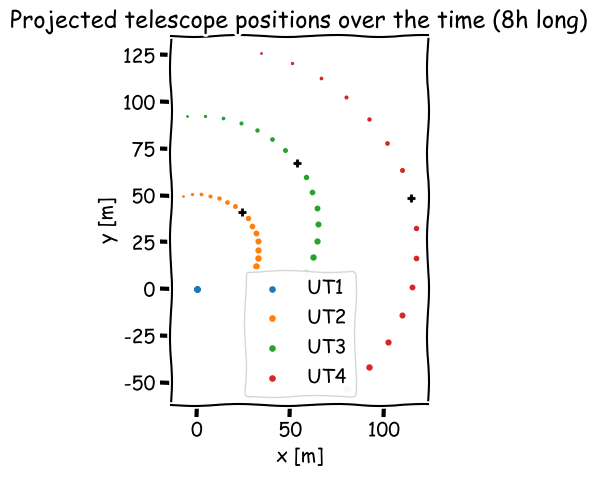

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def plot_telescope_positions(
        h_range = np.linspace(-4,4,15) * 2*np.pi / 24 * u.rad,
        l = LATITUDE,
        δ = DECLINATION,
        return_image = False,
        xkcd=True,
    ):

    with plt.xkcd() as xkcd:
        _, ax = plt.subplots()

        # Plot UT trajectory
        for i, h in enumerate(h_range):
            UTs = project_position(TELESCOPE_POSITIONS, h, l, δ)
            for j, UT in enumerate(UTs):
                ax.scatter(UT[0], UT[1], label=f"UT{j+1}" if i==len(h_range)-1 else None, color=f"C{j}", s=1+14*i/len(h_range))

        # Plot UT positions at T=0
        UTs = project_position(TELESCOPE_POSITIONS, 0*u.hourangle, l, δ)
        for UT in UTs[1:]:
            ax.scatter(UT[0], UT[1], color="black", marker="+")

        ax.set_aspect("equal")
        ax.set_xlabel(f"x [{UTs[0].unit}]")
        ax.set_ylabel(f"y [{UTs[0].unit}]")
        ax.set_title(f"Projected telescope positions over the time (8h long)")
        plt.legend()

        if return_image:
            buffer = BytesIO()
            plt.savefig(buffer,format='png')
            plt.close()
            return buffer.getvalue()
        plt.show()

# Interactive plot ------------------------------------------------------------

def iplot_telescope_positions():
    
    # GUI elements
    h_range = np.linspace(-4,4,15) * 2*np.pi / 24 * u.rad
    l_slider = widgets.FloatSlider(
        value=LATITUDE.to(u.deg).value,
        min=-90,
        max=90,
        step=0.01,
        description='Latitude:',
    )
    δ_slider = widgets.FloatSlider(
        value=DECLINATION.to(u.deg).value,
        min=-90,
        max=90,
        step=0.01,
        description='Declination:',
    )
    reset = widgets.Button(description="Reset to defalut")
    plot = widgets.Image(width=500,height=500)

    # Callbacks
    def update_plot(*_):
        plot.value = plot_telescope_positions(
            h_range=h_range,
            l=l_slider.value*u.deg,
            δ=δ_slider.value*u.deg,
            return_image=True)

    def reset_values(*_):
        l_slider.value = LATITUDE.to(u.deg).value
        δ_slider.value = DECLINATION.to(u.deg).value

    # Triggers
    reset.on_click(reset_values)
    l_slider.observe(update_plot, 'value')
    δ_slider.observe(update_plot, 'value')

    # Display
    display(widgets.VBox([l_slider, δ_slider, reset, plot]))
    update_plot()
    return

plot_telescope_positions(xkcd=False)

## 🔆 Signal nature

The star and the planet are point sources. Seen from a classical telescope, it will result in an image made of the objects convolution with the point spread function (PSF) of the telescope.

$$
I = O \otimes PSF
$$

Here we consider the most simple PSF : the Airy disk. The Airy disk is the diffraction pattern of a point source by a circular aperture. It is given by:

$$
PSF = \left(\frac{2J_1(x)}{x}\right)^2
$$

where $J_1$ is the Bessel function of the first kind of order 1 and $x = \frac{2\pi r}{\lambda f}$ is the normalized radius of the Airy disk.

Then, we focus the image in a monomode optical fiber which will basically only keep the main lobe of the PSF and reshape it in a Gaussian form. In this process, we lose the spatial information so we have no longer images, but the light flux of each object in the fiber can be simply described by a complex number.

Using this formalism, the light flux of the star and the planet can  be described by only 2 complex numbers for each telescope, giving the amplitude and phase of each object.

In [29]:
def get_input_fields(
    c: float = 1,
    θ: u.Quantity = 0 * u.rad,
    α: u.Quantity = 0 * u.rad,
    λ: u.Quantity = L,
    r: u.Quantity = PROJECTED_TELESCOPE_POSITIONS,
) -> np.ndarray[complex]:
    """
    Get the phase of the 4 inputs according to the object and telescope positions.

    Parameters
    ----------
    - c: Contrast with the star
    - θ: Angular separation
    - α: Parallactic angle
    - λ: Wavelength
    - r: Projected telescope positions

    Returns
    -------
    - Array of acquired signals (complex amplitudes)
    """
    α = α.to(u.rad).value
    θ = θ.to(u.rad).value
    λ = λ.to(u.m).value
    r = r.to(u.m).value
    return get_input_fields_njit(c, θ, α, λ, r)

@nb.njit()
def get_input_fields_njit(
    c: float = 1,
    θ: float = 0,
    α: float = 0,
    λ: float = L.to(u.m).value,
    r: np.ndarray[float] = PROJECTED_TELESCOPE_POSITIONS.to(u.m).value,
) -> np.ndarray[complex]:
    """
    Get the complexe amplitude of the input signals according to the object and telescopes positions.

    Parameters
    ----------
    - c: Contrast with the star
    - θ: Angular separation (in radian)
    - α: Parallactic angle (in radian)
    - λ: Wavelength (in meter)
    - r: Projected telescope positions (in meter)

    Returns
    -------
    - Array of acquired signals (complex amplitudes).
    """

    # Array of complex signals
    s = np.empty(r.shape[0], dtype=np.complex128)

    for i, t in enumerate(r):

        # Rotate the projected telescope positions by the parallactic angle
        p_rot = t[0] * np.cos(-α) - t[1] * np.sin(-α)

        # Compute the phase delay according to the object position
        Φ = 2 * np.pi * p_rot * np.sin(θ) / λ

        # Build the complex amplitude of the signal
        s[i] = np.sqrt(c) * np.exp(1j * Φ)

    return s / np.sqrt(r.shape[0])

In [30]:
def signals_as_str(signals: np.ndarray[complex]) -> str:
    """
    Convert signals to a string.

    Parameters
    ----------
    - signals : Signals to convert.

    Returns
    -------
    - String representation of the signals.
    """

    res = ""
    for i, s in enumerate(signals):
        res += f" - Telescope {i}:   {np.abs(s):.2e} *exp(i* {np.angle(s)/np.pi:.2f} *pi)   ->   {np.abs(s)**2:.2e}\n"
    return res[:-1]

## 🔉 Photon noise

The photon noise is the noise due to the quantization of the light in photons. It is a Poisson noise and can be described by the following formula:

$$
\sigma = \sqrt{N}
$$

where $N$ is the number of photons.

The number of photons can be computed using the Light flux $F_\lambda$ of the star and the planet, the collecting area $A$ of the telescope, the bandwidth $\Delta \lambda$, the transmission efficiency $\eta$, the magnitude $M$ of the star, and the energy of a photon $E_\nu$ at the frequency $\nu$.

Light flux is expressed in Jensky:
$$
1\:\text{Jensky} = 1\:Jy = 10^{-26}\:W/m^2/Hz = 10^{-26}\:J/s/m^2/Hz
$$
The flux $F_\lambda$ for a star at different wavelengths is given by tables. The following one is an example for AB class stars such as Vega $^1$:

| Band | $\lambda$ ($\mu m$) | $F_\lambda$ ($Jy$) |
|------|---------------------|--------------------|
| V    | 0.55                | 3540               |
| J    | 1.21                | 1630               |
| H    | 1.65                | 1050               |
| K    | 2.17                | 655                |
| L    | 3.55                | 276                |

The number of acquired photons per second is given by:

$$
N = F_\lambda \times A \times \Delta \nu \times \eta \times 10^{-\frac{M}{2.5}} / E_\nu
$$

where $A$ is the collecting area of the telescope, $\Delta \lambda$ is the bandwidth, $\eta$ is the transmission efficiency of the system, $M$ is the magnitude of the star, and $E_\nu$ is the energy of a photon at the frequency $\nu$.

We can also express the bandwidth and eneergy in terms of the wavelength:
$$
\Delta \nu = \frac{c}{\lambda^2} \Delta \lambda
$$
$$
E_\nu = \frac{h \times c}{\lambda}
$$

where $c$ is the speed of light, $h$ is the Planck constant.

> **References**
> 1. Allen's Astrophysical Quantities

In [11]:
def nb_photons(
        λ:u.Quantity = L,
        Δλ:u.Quantity = SPECTRAL_WIDTH,
        f:u.Quantity = 1050*u.Jy,
        a:u.Quantity = 4 * np.pi * (4*u.m)**2,
        η:float = OPTICAL_EFFICIENCY,
        m:float = STAR_MAGNITUDE.to(u.mag).value,
):
    h = const.h.to(u.J * u.s)
    c = const.c.to(u.m/u.s)
    δν = c/(λ**2) * Δλ
    e = h*c/λ

    return (f * a * δν * η * 10**(-m/2.5) / e).to(1/u.s)

## ⚙️ Context parameters

In [12]:
STAR_FLUX = nb_photons()
STAR_SIGNALS = get_input_fields()

for i, companion in enumerate(COMPANIONS):
    COMPANIONS[i].update(
        {'signals' : get_input_fields(
            c=companion['contrast'],
            θ=companion['angular_separation'],
            α=companion['parallactic_angle'],
    )})

SHIFTS_TOTAL_OPD = bound_phase_njit(SHIFTS_CE_OFFSET.to(L.unit).value + np.random.normal(0, SHIFTS_CE_RMS.to(L.unit).value, size=14), L.value) * L.unit

IDEAL_SHIFTS = bound_phase(-SHIFTS_TOTAL_OPD, L)

## 🏮 MMI

The nulling operation is made using Multi Mode Interferometer (MMI). It consist in a multimode waveguide taking several monomode fibers as input and output. The multimode waveguide is shaped in order to produce a specific interference operation, such as spreading the light of an input on all the output, or opposite, gathering the light of all the input on a single output.

To design a simple nuller, we then need a 2x2 MMI that gather (ie. create a constructive interference) all the input light on a single output. The other output is then a "nulled" output, where there is actually all the inputs light but in phase opposition, resulting in a destructive interference.

<div align=center>
<img src="img/mmi.png" width=400px>

*Numerical simulation of a 3x3 gathering MMI, taken from the paper of Cvetojevic et. al., 2022 $^1$*

</div>

> **Reference**
> 1. Cvetojevic, N. et al., 2022. 3-beam self-calibrated Kernel nulling photonic interferometer. arXiv e-prints. https://doi.org/10.48550/arXiv.2206.04977

## 🔀 Recombiner

The recombiner is also an MMI that will place the signals in phase quadrature. A particularity is that the output of the recombiner contain a symmetry. We will take advantage of this in the Kernel step.

<div align=center>
<img src="img/recombiner.png" width=500px>

*Action of a 2x2 recombiner MMI, taking 2 different combination of 4 nulled signals as input. Taken from the paper of Romain Laugier et al., 2020 $^1$*

</div>

In a 2 input case, we can express the recombiner operation using the following matrix:

$$  
R = \frac{1}{\sqrt{2}}\begin{pmatrix}
e^{i\pi/4} & e^{-i\pi/4} \\
e^{-i\pi/4} & e^{i\pi/4}
\end{pmatrix}
$$

> **Reference**
> 1. Laugier, R., Cvetojevic, N., Martinache, F., 2020. Kernel nullers for an arbitrary number of apertures. A&A 642, A202. https://doi.org/10.1051/0004-6361/202038866


In [13]:
@nb.njit()
def cross_recombiner_2x2(beams:np.array) -> np.array:
    """
    Simulate a 2x2 cross recombiner MMI

    Parameters
    ----------
    - beams: Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
    """

    θ:float=np.pi/2

    # Cross recombiner matrix
    S = 1/np.sqrt(2) * np.array([
        [np.exp(1j*θ/2), np.exp(-1j*θ/2)],
        [np.exp(-1j*θ/2), np.exp(1j*θ/2)]
    ])

    # Operation
    return S @ beams

## 💠 Kernel

The idea of the kernel is to acquire and substract the pairs of recombined output. As these pairs share symmetrical properties, this substraction will cancel the star light even with first order phase aberations while keeping the planet light!

Moreover, it modify the nuller response (cf. "Transmission maps" section below) in an asymetric way which is interesting for us as it gives us more information to constrain the planet position.

Demonstration:

In [14]:
def demonstration():

    # Elements definition
    I = sp.IndexedBase("I", real=True)  # Kernel intensity
    E = sp.IndexedBase("E")  # Electric field
    A = sp.IndexedBase("A", real=True)  # Amplitude
    P = sp.IndexedBase("phi", real=True)  # Relative phase
    T = sp.IndexedBase("theta", real=True)  # Phase perturbation
    a = sp.symbols("a", cls=sp.Idx)  # First dark
    b = sp.symbols("b", cls=sp.Idx)  # Second dark
    s = sp.symbols("s", cls=sp.Idx)  # Star index
    p = sp.symbols("p", cls=sp.Idx)  # Planet index

    # Intensity in a dark output is the sum of the intensities coming from the star and from the planet
    Ia = I[a, s] + I[a, p]
    Ib = I[b, s] + I[b, p]
    print("Input intensities:")
    display(Ia, Ib)

    # Developping Intensities as interference of the electrical fields
    Ias = abs(E[1, s] + E[2, s] + E[3, s] + E[4, s]) ** 2
    Iap = abs(E[1, p] + E[2, p] + E[3, p] + E[4, p]) ** 2
    Ibs = abs(E[1, s] + E[2, s] + E[3, s] + E[4, s]) ** 2
    Ibp = abs(E[1, p] + E[2, p] + E[3, p] + E[4, p]) ** 2

    Ia = Ia.subs(I[a, s], Ias).subs(I[a, p], Iap)
    Ib = Ia.subs(I[b, s], Ibs).subs(I[b, p], Ibp)
    print("Fields contributions:")
    display(Ia, Ib)

    # Expressing the electric fields as a function of the amplitudes and the relative phases
    E1s = A[s]
    E2s = A[s] * (1 + sp.I * T[2])
    E3s = A[s] * (1 + sp.I * T[3])
    E4s = A[s] * (1 + sp.I * T[4])
    E1p = A[p] * sp.exp(sp.I * P[1])
    E2p = A[p] * sp.exp(sp.I * P[2]) * (1 + sp.I * T[2])
    E3p = A[p] * sp.exp(sp.I * P[3]) * (1 + sp.I * T[3])
    E4p = A[p] * sp.exp(sp.I * P[4]) * (1 + sp.I * T[4])

    # Relative phase : E1 -> 0, E2 -> pi, E3 -> pi/2, E4 -> -pi/2
    Ia = (
        Ia.subs(E[1, s], E1s)
        .subs(E[2, s], -E2s)
        .subs(E[3, s], sp.I * E3s)
        .subs(E[4, s], -sp.I * E4s)
    )
    Ia = (
        Ia.subs(E[1, p], E1p)
        .subs(E[2, p], -E2p)
        .subs(E[3, p], sp.I * E3p)
        .subs(E[4, p], -sp.I * E4p)
    )
    # Relative phase : E1 -> 0, E2 -> pi, E3 -> -pi/2, E4 -> pi/2
    Ib = (
        Ib.subs(E[1, p], E1p)
        .subs(E[2, p], -E2p)
        .subs(E[3, p], -sp.I * E3p)
        .subs(E[4, p], sp.I * E4p)
    )
    Ib = (
        Ib.subs(E[1, s], E1s)
        .subs(E[2, s], -E2s)
        .subs(E[3, s], -sp.I * E3s)
        .subs(E[4, s], sp.I * E4s)
    )
    print("Decomposition in amplitudes and phases:")
    display(Ia.expand().simplify(), Ib.expand().simplify())

    # Kernel intensity
    Ik = Ia - Ib
    print("Difference between the signals")
    display(Ik.expand().simplify())

# demonstration()

## 🌡️ Thermo-optic phase shifter

In practice, we are often limited by the fabrication process of the optical components. The imperfections can lead into phase aberations that will degrade the Kernel-Nuller performance. An attempt to correct these aberations consist in using thermo-optic phase shifters. It consist in a waveguide with a heater that will modify the refractive index of the waveguide and thus the phase of the light passing through it.

As the size of the waveguide is very small, the thermal inertia is very low and the phase can be modified very quickly, in a milisecond time scale. This is a very interesting solution to correct phase aberations, even in real time if we encounter variable phase aberation sources.

<div align=center>
<img src="img/thermo-optic_phase_shifter.png" width=500px>
</div>

In this simulation, one will simply modelize these phase shifter as a phase shift in the signal.

$$
P = e^{i\phi} = e^{i\frac{2\pi}{\lambda} \Delta L}
$$

Where $\phi$ and $\Delta L$ are proportional to the power injected in the heater.

In [15]:
@nb.njit()
def phase_shift_njit(
    ψ: complex | np.ndarray[complex],
    δφ: float | np.ndarray[float],
    λ: float = L.value,
) -> complex | np.ndarray[complex]:
    """
    De-phase the input beam by heating the fiber with an electrical current.

    Parameters
    ----------
    - ψ: input beam complex amplitude
    - δφ: phase to add (in same unit as wavelenght)
    - λ: wavelength

    Returns
    -------
    - Output beam complex amplitude
    """
    return ψ * np.exp(1j * 2 * π * δφ / λ)


def phase_shift(
    ψ: complex | np.ndarray[complex],
    δφ: u.Quantity,
    λ: u.Quantity = L
) -> complex | np.ndarray[complex]:
    """
    De-phase the input beam by heating the fiber with an electrical current.

    Parameters
    ----------
    - ψ: input beam complex amplitude
    - δφ: phase to add
    - λ: wavelength

    Returns
    -------
    - Output beam complex amplitude
    """
    δφ = δφ.to(λ.unit).value
    λ = λ.value
    return phase_shift_njit(ψ, δφ, λ)

---

<div align=center>

# 💡 **Our approach**

</div>

## 🏗️ Current architecture

To implement the 4 telescope tunable Kernel-Nuller, we splitted the 4x4 MMI into series of 2x2 MMI separated by phase shifters.

<div align=center>
<img src="img/scheme.png" width=1000px>

*Architecture of our Kernel-Nuller. N suqares are the 2x2 nullers, S squares are the 2x2 recombiners and P rectangles are the phase shifters*

</div>

In [16]:
def kn_fields(
    ψ: np.ndarray[complex],
    p: u.Quantity = np.zeros(14) * L.unit,
    σ: u.Quantity = SHIFTS_TOTAL_OPD,
    λ: u.Quantity = L,
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - ψ: Array of 4 input signals complex amplitudes
    - p: Array of 14 injected OPD
    - σ: Array of 14 intrasic OPD error
    - λ: Wavelength of the light

    Returns
    -------
    - Array of 3 null outputs electric fields
    - Array of 6 dark outputs electric fields
    - Bright output electric fields
    """
    p = p.to(λ.unit).value
    σ = σ.to(λ.unit).value
    λ = λ.value
    return kn_fields_njit(ψ, p, σ, λ)

@nb.njit()
def kn_fields_njit(
    ψ: np.ndarray[complex],
    p: np.ndarray[float] = np.zeros(14),
    σ: np.ndarray[float] = SHIFTS_TOTAL_OPD.to(L.unit).value,
    λ: float = L.value,
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - ψ: Array of 4 input signals complex amplitudes
    - p: Array of 14 injected OPD (in wavelenght unit)
    - σ: Array of 14 intrasic OPD error (in wavelenght unit)
    - λ: Wavelength of the light

    Returns
    -------
    - Array of 3 null outputs electric fields
    - Array of 6 dark outputs electric fields
    - Bright output electric fields
    """

    p = bound_phase_njit(p + σ, λ)

    # First layer of pahse shifters
    nuller_inputs = phase_shift_njit(ψ, p[:4], λ)

    # First layer of nulling
    N1 = nuller_2x2(nuller_inputs[:2])
    N2 = nuller_2x2(nuller_inputs[2:])

    # Second layer of phase shifters
    N1_shifted = phase_shift_njit(N1, p[4:6], λ)
    N2_shifted = phase_shift_njit(N2, p[6:8], λ)

    # Second layer of nulling
    N3 = nuller_2x2(np.array([N1_shifted[0], N2_shifted[0]]))
    N4 = nuller_2x2(np.array([N1_shifted[1], N2_shifted[1]]))

    nulls = np.array([N3[1], N4[0], N4[1]], dtype=np.complex128)
    bright = N3[0]

    # Beam splitting
    S_inputs = np.array([N3[1], N3[1], N4[0], N4[0], N4[1], N4[1]]) * 1 / np.sqrt(2)

    # Last layer of phase shifters
    S_inputs = phase_shift_njit(S_inputs, p[8:], λ)

    # Beam mixing
    S1_output = cross_recombiner_2x2(np.array([S_inputs[0], S_inputs[2]]))
    S2_output = cross_recombiner_2x2(np.array([S_inputs[1], S_inputs[4]]))
    S3_output = cross_recombiner_2x2(np.array([S_inputs[3], S_inputs[5]]))

    darks = np.array(
        [
            S1_output[0],
            S1_output[1],
            S2_output[0],
            S2_output[1],
            S3_output[0],
            S3_output[1],
        ],
        dtype=np.complex128,
    )

    return nulls, darks, bright

In [17]:
def kn(
    ψ: np.ndarray[complex],
    p: u.Quantity = np.zeros(14) * L.unit,
    σ: u.Quantity = SHIFTS_TOTAL_OPD,
    λ: u.Quantity = L,
    dt:u.Quantity = DT,
    f: float = STAR_FLUX,
) -> np.ndarray[float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - ψ: Array of 4 input beams complex amplitudes
    - p: Array of 14 injected OPD
    - σ: Array of 14 intrasic OPD
    - λ: Wavelength of the light
    - dt: Exposure time
    - f: Star flux (in photon/s). If set, the output will be a number of photons. If None, the output will correspond to the throughput.

    Returns
    -------
    - Array of 6 dark outputs intensities
    - Array of 3 kernels output intensities
    - Bright output intensity
    """
    p = p.to(λ.unit).value
    σ = σ.to(λ.unit).value
    dt = dt.to(u.s).value
    f = f.to(1/u.s).value
    return kn_njit(ψ, p, σ, λ.value, dt, f)

@nb.njit()
def kn_njit(
    ψ: np.ndarray[complex],
    p: u.Quantity = np.zeros(14) * L.unit,
    σ: u.Quantity = SHIFTS_TOTAL_OPD,
    λ: u.Quantity = L,
    dt:float = DT.to(u.s).value,
    f: float = STAR_FLUX.to(1/u.s).value,
) -> np.ndarray[float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - ψ: Array of 4 input beams complex amplitudes
    - p: Array of 14 injected OPD
    - σ: Array of 14 intrasic OPD
    - λ: Wavelength of the light
    - dt: Exposure time in seconds
    - f: Star flux (in photon/s). If set, the output will be a number of photons. If None, the output will correspond to the throughput.

    Returns
    -------
    - Array of 6 dark outputs intensities
    - Array of 3 kernels outputs intensities
    - Bright output intensity
    """

    _, d, b = kn_fields_njit(ψ, p, σ, λ)

    # Get intensities
    d = np.abs(d) ** 2
    b = np.abs(b) ** 2

    # Add photon noise
    if f is not None:
        for i in range(3):
            d[i] = np.random.poisson(np.floor(d[i] * f * dt))
        b = np.random.poisson(np.floor(b * f * dt))

    # Create kernels
    k = np.array([d[0]-d[1], d[2]-d[3], d[4]-d[5]])

    return d, k, b

kn(np.array([0.5, 0.5, 0.5, 0.5]))

(array([1.79088800e+06, 1.73169100e+06, 1.11385000e+06, 2.04898020e-04,
        1.08689308e-04, 1.16154279e-04]),
 array([ 5.91970000e+04,  1.11385000e+06, -7.46497112e-06]),
 5785871477.0)

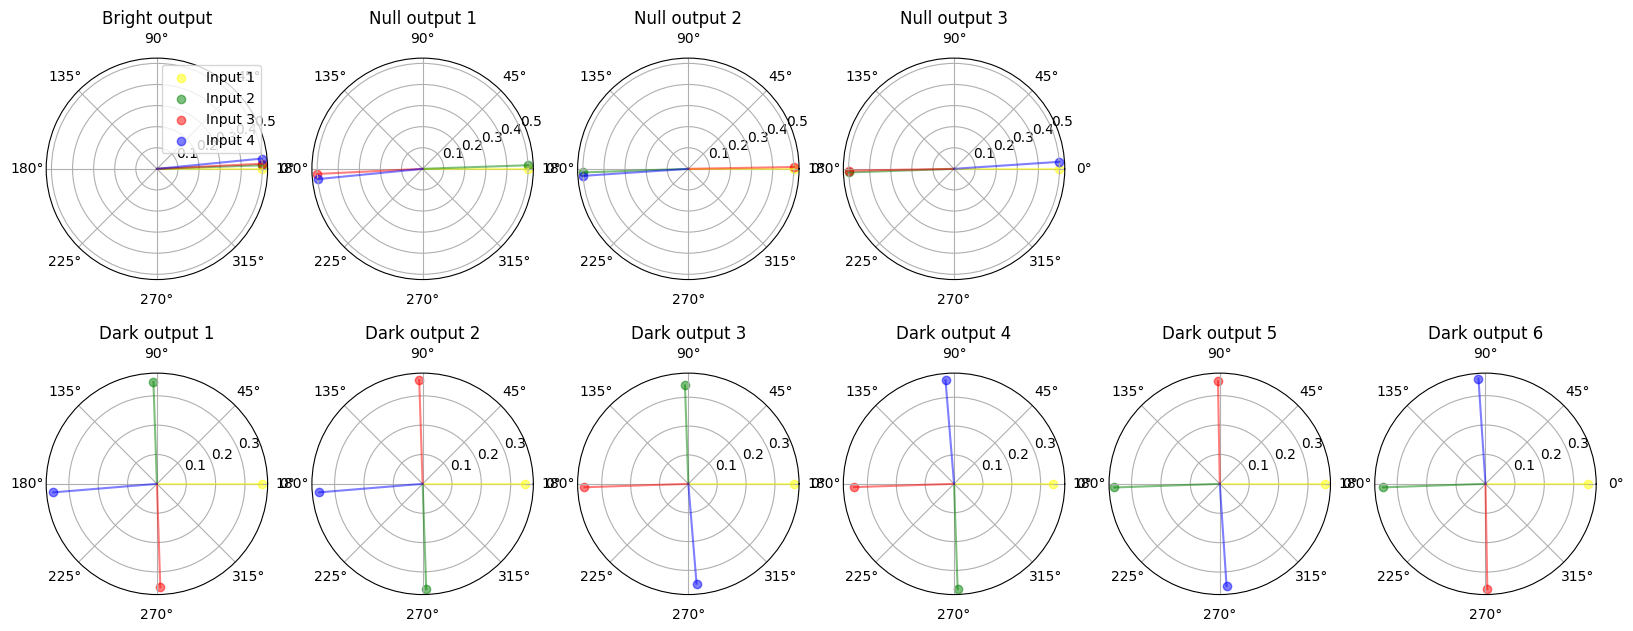

In [18]:
def plot_kn_phase_effect(
        p=np.zeros(14)*L.unit,
        ψ=np.array([1+0j, 1+0j, 1+0j, 1+0j]),
        plot=True
    ):

    ψ1 = np.array([ψ[0], 0, 0, 0])
    ψ2 = np.array([0, ψ[1], 0, 0])
    ψ3 = np.array([0, 0, ψ[2], 0])
    ψ4 = np.array([0, 0, 0, ψ[3]])

    n1, d1, b1 = kn_fields(ψ1, p)
    n2, d2, b2 = kn_fields(ψ2, p)
    n3, d3, b3 = kn_fields(ψ3, p)
    n4, d4, b4 = kn_fields(ψ4, p)

    # Using first signal as reference
    n2 = np.abs(n2) * np.exp(1j * (np.angle(n2) - np.angle(n1)))
    n3 = np.abs(n3) * np.exp(1j * (np.angle(n3) - np.angle(n1)))
    n4 = np.abs(n4) * np.exp(1j * (np.angle(n4) - np.angle(n1)))
    d2 = np.abs(d2) * np.exp(1j * (np.angle(d2) - np.angle(d1)))
    d3 = np.abs(d3) * np.exp(1j * (np.angle(d3) - np.angle(d1)))
    d4 = np.abs(d4) * np.exp(1j * (np.angle(d4) - np.angle(d1)))
    b2 = np.abs(b2) * np.exp(1j * (np.angle(b2) - np.angle(b1)))
    b3 = np.abs(b3) * np.exp(1j * (np.angle(b3) - np.angle(b1)))
    b4 = np.abs(b4) * np.exp(1j * (np.angle(b4) - np.angle(b1)))
    n1 = np.abs(n1) * np.exp(1j * 0)
    d1 = np.abs(d1) * np.exp(1j * 0)
    b1 = np.abs(b1) * np.exp(1j * 0)

    _, axs = plt.subplots(2, 6, figsize=(20, 7.5), subplot_kw={'projection': 'polar'})

    # Bright output
    axs[0,0].scatter(np.angle(b1), np.abs(b1), color="yellow", label='Input 1', alpha=0.5)
    axs[0,0].plot([0, np.angle(b1)], [0, np.abs(b1)], color="yellow", alpha=0.5)
    axs[0,0].scatter(np.angle(b2), np.abs(b2), color="green", label='Input 2', alpha=0.5)
    axs[0,0].plot([0, np.angle(b2)], [0, np.abs(b2)], color="green", alpha=0.5)
    axs[0,0].scatter(np.angle(b3), np.abs(b3), color="red", label='Input 3', alpha=0.5)
    axs[0,0].plot([0, np.angle(b3)], [0, np.abs(b3)], color="red", alpha=0.5)
    axs[0,0].scatter(np.angle(b4), np.abs(b4), color="blue", label='Input 4', alpha=0.5)
    axs[0,0].plot([0, np.angle(b4)], [0, np.abs(b4)], color="blue", alpha=0.5)
    axs[0,0].set_title('Bright output')

    for n in range(3):
        axs[0,n+1].scatter(np.angle(n1[n]), np.abs(n1[n]), color="yellow", label='Input 1', alpha=0.5)
        axs[0,n+1].plot([0, np.angle(n1[n])], [0, np.abs(n1[n])], color="yellow", alpha=0.5)
        axs[0,n+1].scatter(np.angle(n2[n]), np.abs(n2[n]), color="green", label='Input 2', alpha=0.5)
        axs[0,n+1].plot([0, np.angle(n2[n])], [0, np.abs(n2[n])], color="green", alpha=0.5)
        axs[0,n+1].scatter(np.angle(n3[n]), np.abs(n3[n]), color="red", label='Input 3', alpha=0.5)
        axs[0,n+1].plot([0, np.angle(n3[n])], [0, np.abs(n3[n])], color="red", alpha=0.5)
        axs[0,n+1].scatter(np.angle(n4[n]), np.abs(n4[n]), color="blue", label='Input 4', alpha=0.5)
        axs[0,n+1].plot([0, np.angle(n4[n])], [0, np.abs(n4[n])], color="blue", alpha=0.5)
        axs[0,n+1].set_title(f'Null output {n+1}')

    for d in range(6):
        axs[1,d].scatter(np.angle(d1[d]), np.abs(d1[d]), color="yellow", label='I1', alpha=0.5)
        axs[1,d].plot([0, np.angle(d1[d])], [0, np.abs(d1[d])], color="yellow", alpha=0.5)
        axs[1,d].scatter(np.angle(d2[d]), np.abs(d2[d]), color="green", label='I2', alpha=0.5)
        axs[1,d].plot([0, np.angle(d2[d])], [0, np.abs(d2[d])], color="green", alpha=0.5)
        axs[1,d].scatter(np.angle(d3[d]), np.abs(d3[d]), color="red", label='I3', alpha=0.5)
        axs[1,d].plot([0, np.angle(d3[d])], [0, np.abs(d3[d])], color="red", alpha=0.5)
        axs[1,d].scatter(np.angle(d4[d]), np.abs(d4[d]), color="blue", label='I4', alpha=0.5)
        axs[1,d].plot([0, np.angle(d4[d])], [0, np.abs(d4[d])], color="blue", alpha=0.5)
        axs[1,d].set_title(f'Dark output {d+1}')

    axs[0, 4].axis("off")
    axs[0, 5].axis("off")

    axs[0,0].legend()

    if not plot:
        plot = BytesIO()
        plt.savefig(plot, format='png')
        plt.close()
        return plot.getvalue()
    plt.show()

plot_kn_phase_effect()

## 🗺️ Transmission maps

The nulling technic with two telescope show a limitation: if the planet light arrive on the two telescopes with a phase shift of $2n\pi$, the light will also be cancelled. It result in a comb-shaped transmission map $^1$, perpendicular to the baseline (there is clear bands where it's optimal to detect the planet and black bands where we will mostly destroy the planet light).

The idea of Bracewell was to rotate the baseline in order to let the planet pass through the clear bands at some point. After an entire rotation of the baseline, we will have a sinusoidal signal from which the frequency will indicate us the distance of the planet to it's star, and the phase will give us a clue about the angle between the axes star-planet and the axes of the baseline. Thus, as the transmission map is symmetric, we can constrain the planet position to 2 possible locations, on both sides of the star.

Here, we are using 4 telescopes, resulting in more complexe transmission maps than simple combs, but the principle is the same.

> **Reference**
> 1. Bracewell, R.N., MacPhie, R.H., 1979. Searching for nonsolar planets. Icarus 38, 136–147. https://doi.org/10.1016/0019-1035(79)90093-9

In [19]:
@nb.njit()
def get_uv_map_njit(
        N:int=100,
        fov:float=FOV.to(u.rad).value
    ) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], np.ndarray[float]]:
    """
    Generate a map of theta and alpha values for a given resolution.

    Parameters
    ----------
    - N: Resolution of the map
    - fov: Range of field of view values

    Returns
    -------
    - Normalized U map (resolution x resolution)
    - Normalized V map (resolution x resolution)
    - Theta map (resolution x resolution)
    - Alpha map (resolution x resolution)
    """

    # Recreate np.meshgrid() compatible with numba
    x = np.zeros((N, N))
    y = np.zeros((N, N))
    for i, v in enumerate(np.linspace(-1, 1, N)):
        x[:, i] = v
        y[i, :] = v

    theta_map = np.sqrt(x**2 + y**2) * fov
    alpha_map = np.arctan2(y, x)
    alpha_map = alpha_map % (2*np.pi)

    return x, y, theta_map, alpha_map

def get_uv_map(
    resolution: int = 100,
    fov: u.Quantity = FOV,
) -> tuple[np.ndarray[float], np.ndarray[float], u.Quantity, u.Quantity]:
    """
    Generate a map of theta and alpha values for a given resolution.

    Parameters
    ----------
    - resolution: Resolution of the map
    - fov: Range of field of view values

    Returns
    -------
    - Normalized U map (resolution x resolution)
    - Normalized V map (resolution x resolution)
    - Theta map (resolution x resolution)
    - Alpha map (resolution x resolution, in radian)
    """

    x, y, theta_map, alpha_map = get_uv_map_njit(resolution=resolution, fov=fov.to(u.rad).value)

    theta_map = (theta_map * u.rad).to(fov.unit)
    alpha_map = (alpha_map * u.rad).to(u.rad)

    return x, y, theta_map, alpha_map

In [20]:
def plot_uv_map():
    x, y, θ, α = get_uv_map()

    _, axs = plt.subplots(2, 2, figsize=(13, 10))
    
    im = axs[0, 0].imshow(x, extent=EXTENT, cmap='viridis')
    axs[0, 0].set_title("U map (px)")
    axs[0, 0].set_xlabel("U")
    axs[0, 0].set_ylabel("V")
    plt.colorbar(im, ax=axs[0, 0])

    im = axs[0, 1].imshow(y, extent=EXTENT, cmap='viridis')
    axs[0, 1].set_title("V map (px)")
    axs[0, 1].set_xlabel("U")
    axs[0, 1].set_ylabel("V")
    plt.colorbar(im, ax=axs[0, 1])

    im = axs[1, 0].imshow(θ.value, extent=EXTENT, cmap='viridis')
    axs[1, 0].set_title(f"Theta map ({θ.unit})")
    axs[1, 0].set_xlabel("U")
    axs[1, 0].set_ylabel("V")
    plt.colorbar(im, ax=axs[1, 0])

    im = axs[1, 1].imshow(α.value, extent=EXTENT, cmap='viridis')
    axs[1, 1].set_title(f"Alpha map ({α.unit})")
    axs[1, 1].set_xlabel("U")
    axs[1, 1].set_ylabel("V")
    plt.colorbar(im, ax=axs[1, 1])

    plt.show()

# plot_uv_map()

In [21]:
@nb.njit()
def αθ_to_xy_njit(
        α: float,
        θ: float,
        fov: float = FOV.to(u.rad).value
    ) -> tuple[float, float]:
    """
    Convert alpha and theta values to the x and y angle from the center of the field of view.

    Parameters
    ----------
    - α: Parallactic angle (rad)
    - θ: Angular separation (rad)
    - fov: Field of view (rad)

    Returns
    -------
    - U value
    - V value
    """
    
    x = θ/fov * np.cos(α)
    y = θ/fov * np.sin(α)

    return x, y

def αθ_to_xy(
    α: u.Quantity,
    θ: u.Quantity,
    fov: u.Quantity = FOV,
) -> tuple[u.Quantity, u.Quantity]:
    """
    Convert alpha and theta values to the x and y angle from the center of the field of view.

    Parameters
    ----------
    - α: Parallactic angle
    - θ: Angular separation
    - fov: Field of view

    Returns
    -------
    - U value
    - V value
    """
    α = α.to(u.rad).value
    θ = θ.to(u.rad).value
    fov = fov.to(u.rad).value
    return αθ_to_xy_njit(α, θ)

In [22]:
@nb.njit()
def get_transmission_map_njit(
    N: int = 100,
    p: np.ndarray[float] = np.zeros(14),
    σ: np.ndarray[float] = np.zeros(14),
    r: np.ndarray[float] = PROJECTED_TELESCOPE_POSITIONS.value,
) -> tuple[np.ndarray[complex], np.ndarray[complex], np.ndarray[float]]:
    """
    Generate all the kernel-nuller transmission maps for a given resolution

    Parameters
    ----------
    - N: Resolution of the map
    - p: Array of 14 injected OPD (in wavelenght unit)
    - σ: Array of 14 intrasic OPD (in wavelenght unit)
    - r: Telescope positions (in meter)

    Returns
    -------
    - Null outputs map (3 x resolution x resolution)
    - Dark outputs map (6 x resolution x resolution)
    - Kernel outputs map (3 x resolution x resolution)
    """

    _, _, θ_map, α_map = get_uv_map_njit(N=N)

    n_maps = np.zeros((3, N, N), dtype=np.complex128)
    d_maps = np.zeros((6, N, N), dtype=np.complex128)
    k_maps = np.zeros((3, N, N), dtype=float)

    for x in range(N):
        for y in range(N):

            θ = θ_map[x, y]
            α = α_map[x, y]

            ψ = get_input_fields_njit(θ=θ, α=α, r=r)

            n, d, _ = kn_fields_njit(ψ, p, σ)

            k = np.array([np.abs(d[2*i])**2 - np.abs(d[2*i+1])**2 for i in range(3)])

            for i in range(3):
                n_maps[i, x, y] = n[i]

            for i in range(6):
                d_maps[i, x, y] = d[i]

            for i in range(3):
                k_maps[i, x, y] = k[i]

    return np.abs(n_maps) ** 2, np.abs(d_maps) ** 2, k_maps


def get_transmission_map(
    N = 100,
    p: u.Quantity = np.zeros(14) * L.unit,
    σ: u.Quantity = np.zeros(14) * L.unit,
    r: u.Quantity = PROJECTED_TELESCOPE_POSITIONS,
) -> tuple[np.ndarray[complex], np.ndarray[complex], np.ndarray[float]]:
    """
    Generate all the kernel-nuller transmission maps for a given resolution

    Parameters
    ----------
    - N: Resolution of the map
    - p: Array of 14 injected OPD
    - σ: Array of 14 intrasic OPD
    - r: Telescope positions

    Returns
    -------
    - Null outputs map (3 x resolution x resolution)
    - Dark outputs map (6 x resolution x resolution)
    - Kernel outputs map (3 x resolution x resolution)
    """
    p = p.to(L.unit).value
    σ = σ.to(L.unit).value
    r = r.to(u.m).value

    return get_transmission_map_njit(N, p, σ, r)

In [23]:
def plot_transmission_maps(
    p: u.Quantity = np.zeros(14) * L.unit,
    σ: u.Quantity = np.zeros(14) * L.unit,
    N: int = 100,
    h: float = 0*u.deg,
    l: float = LATITUDE,
    δ: float = DECLINATION,
    companions: list[dict] = COMPANIONS,
    return_plot=False
) -> None:
    
    # Get transmission maps
    r = project_position(TELESCOPE_POSITIONS, h=h, l=l, δ=δ)
    n_maps, d_maps, k_maps = get_transmission_map(N, p, σ, r)

    # Get companions position to plot them
    companions_pos = []
    for companion in companions:
        α = companion["parallactic_angle"]
        θ = companion["angular_separation"]
        x, y = αθ_to_xy(α, θ)
        companions_pos.append((x*np.sqrt(N), y*np.sqrt(N)))

    _, axs = plt.subplots(2, 6, figsize=(35, 10))

    for i in range(3):
        im = axs[0, i].imshow(n_maps[i], aspect="equal", cmap="hot", extent=EXTENT)
        axs[0, i].set_title(f"Nuller output {i+1}")
        plt.colorbar(im, ax=axs[0, i])

    for i in range(6):
        im = axs[1, i].imshow(d_maps[i], aspect="equal", cmap="hot", extent=EXTENT)
        axs[1, i].set_title(f"Dark output {i+1}")
        axs[1, i].set_aspect("equal")
        plt.colorbar(im, ax=axs[1, i])

    for i in range(3):
        im = axs[0, i + 3].imshow(k_maps[i], aspect="equal", cmap="bwr", extent=EXTENT)
        axs[0, i + 3].set_title(f"Kernel {i+1}")
        plt.colorbar(im, ax=axs[0, i + 3])

    for ax in axs.flatten():
        ax.set_xlabel(r"$\theta_x$" + f" ({FOV.unit})")
        ax.set_ylabel(r"$\theta_y$" + f" ({FOV.unit})")
        ax.scatter(0, 0, color="yellow", marker="*", edgecolors="black")
        for x, y in companions_pos:
            ax.scatter(x, y, color="blue", edgecolors="black")

    transmissions = ""
    for i, companion in enumerate(companions):
        α = companion["parallactic_angle"]
        θ = companion["angular_separation"]
        s = get_input_fields(θ=θ, α=α)

        n, d, b = kn_fields(s, σ=np.zeros(14) * L.unit)

        k = np.array([np.abs(d[2*i])**2 - np.abs(d[2*i+1])**2 for i in range(3)])

        linebreak = '<br>' if return_plot else '\n   '
        transmissions += '<h2>' if return_plot else ''
        transmissions += f"Companion {i+1} throughputs:"
        transmissions += '</h1>' if return_plot else '\n----------' + linebreak
        transmissions += f"B: {np.abs(b)**2*100:.2f}%" + linebreak
        transmissions += f"N: {' | '.join([f'{np.abs(i)**2*100:.2f}%' for i in n])}" + linebreak
        transmissions += f"D: {' | '.join([f'{np.abs(i)**2*100:.2f}%' for i in d])}" + linebreak
        transmissions += f"K: {' | '.join([f'{i*100:.2f}%' for i in k])}" + linebreak

    if return_plot:
        plot = BytesIO()
        plt.savefig(plot, format='png')
        plt.close()
        return plot.getvalue(), transmissions
    plt.show()
    print(transmissions)

# Interactive plot ------------------------------------------------------------
    
def iplot_transmission_maps(N=100):

    # UI elements
    h_slider = widgets.FloatSlider(value=0, min=-DH.value/2, max=DH.value/2, step=0.01, description='Hour angle:')
    l_slider = widgets.FloatSlider(value=LATITUDE.to(u.deg).value, min=-90, max=90, step=0.01, description='Latitude:')
    δ_slider = widgets.FloatSlider(value=DECLINATION.to(u.deg).value, min=-90, max=90, step=0.01, description='Declination:')
    reset = widgets.Button(description="Reset values")
    run = widgets.Button(description="Run")
    plot = widgets.Image()
    transmission = widgets.HTML()

    def update_plot(*args):
        run.button_style = "warning"
        
        img, txt = plot_transmission_maps(
            N=N,
            h=h_slider.value*u.deg,
            l=l_slider.value*u.deg,
            δ=δ_slider.value*u.deg,
            return_plot=True
        )
        plot.value = img
        transmission.value = txt
        
        run.button_style = ""

    def reset_values(*args):
        h_slider.value = 0
        l_slider.value = LATITUDE.to(u.deg).value
        δ_slider.value = DECLINATION.to(u.deg).value
        run.color = "blue"
        enable_run()

    def enable_run(*args):
        run.button_style = "success"
    
    reset.on_click(reset_values)
    h_slider.observe(enable_run)
    l_slider.observe(enable_run)
    δ_slider.observe(enable_run)
    run.on_click(update_plot)
    display(widgets.VBox([h_slider, l_slider, δ_slider, widgets.HBox([reset, run]), plot, transmission]))
    update_plot()

iplot_transmission_maps(N=100)

---

<div align=center>

# 🪛 **Calibration**

</div>

## 🫳 Manual shift controls

In [24]:
def manual_shift_control():
    step = 1e-20

    # Build sliders -----------------------------------------------------------

    # Input amplitude
    IA_sliders = [
        widgets.FloatSlider(
            value=1/np.sqrt(4), min=0, max=1, step=step, description=f"I{i+1}",
            continuous_update=False,
        )
        for i in range(4)
    ]

    # Input phase
    IP_sliders = [
        widgets.FloatSlider(
            value=0, min=0, max=L.value, step=step, description=f"I{i+1}",
            continuous_update=False,
        )
        for i in range(4)
    ]

    # Shifter phase
    P_sliders = [
        widgets.FloatSlider(
            value=0, min=0, max=L.value, step=step, description=f"P{i+1}",
            continuous_update=False,
        )
        for i in range(14)
    ]

    # Build GUI ---------------------------------------------------------------

    def beam_repr(beam: complex) -> str:
        return f"<b>{np.abs(beam):.2e}</b> * exp(<b>{np.angle(beam)/np.pi:.2f}</b> pi i)"

    inputs = [widgets.HTML(value=f" ") for _ in range(4)]
    null_outputs = [widgets.HTML(value=f" ") for _ in range(4)]
    dark_outputs = [widgets.HTML(value=f" ") for _ in range(6)]
    kernel_outputs = [widgets.HTML(value=f" ") for _ in range(3)]

    def update_gui(*args):

        ψ = np.array([
            IA_sliders[i].value * np.exp(1j * IP_sliders[i].value / L.value * 2 * np.pi)
            for i in range(4)
        ])

        n, d, b = kn_fields(ψ=ψ, p=np.array([x.value for x in P_sliders]) * L.unit)

        k = np.array([
            np.abs(d[2*i])**2 - np.abs(d[2*i+1])**2
        for i in range(3)])

        for i, beam in enumerate(ψ):
            inputs[i].value = (
                f"<b>Input {i+1} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2*100:.1f}%</b></code>"
            )
        null_outputs[0].value = (
            f"<b>N3a -</b> Amplitude: <code>{beam_repr(b)}</code> Intensity: <code><b>{np.abs(b)**2*100:.1f}%</b></code> <b><- Bright channel</b>"
        )
        for i, beam in enumerate(n):
            null_outputs[i + 1].value = (
                f"<b>N{(i-1)//2+4}{['a','b'][(i+1)%2]} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2*100:.1f}%</b></code>"
            )
        for i, beam in enumerate(d):
            dark_outputs[i].value = (
                f"<b>Dark {i+1} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2*100:.1f}%</b></code>"
            )
        for i, beam in enumerate(k):
            kernel_outputs[i].value = (
                f"<b>Kernel {i+1} -</b> Value: <code>{beam:.2e}</code>"
            )   
            
        # fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        phases.value = plot_kn_phase_effect(
            ψ = ψ,
            p = np.array([p.value for p in P_sliders])*L.unit,
            plot = False
            )

        # Plot intensities
        for i in range(len(ψ)):
            plt.imshow([[np.abs(ψ[i])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(ψ)**2))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                photometric_cameras[i].value = image
        for i in range(len(n)+1):
            if i == 0:
                plt.imshow([[np.abs(b)**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(n)**2) + np.abs(b)**2)
            else:
                plt.imshow([[np.abs(n[i-1])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(n)**2) + np.abs(b)**2)
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                null_cameras[i].value = image
        for i in range(len(d)):
            plt.imshow([[np.abs(d[i])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(d)**2))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                dark_cameras[i].value = image
        for i in range(len(k)):
            plt.imshow([[k[i],],], cmap="bwr", vmin=-np.max(np.abs(k)), vmax=np.max(np.abs(k)))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                kernel_cameras[i].value = image

        os.remove("img/tmp.png")

        return b, d
    
    photometric_cameras = [widgets.Image(width=50,height=50) for _ in range(4)]
    null_cameras = [widgets.Image(width=50,height=50) for _ in range(4)]
    dark_cameras = [widgets.Image(width=50,height=50) for _ in range(6)]
    kernel_cameras = [widgets.Image(width=50,height=50) for _ in range(3)]
    phases = widgets.Image()

    vbox = widgets.VBox(
        [
            widgets.HTML("<h1>Inputs</h1>"),
            widgets.HTML("Amplitude:"),
            widgets.HBox(IA_sliders[:4]),
            widgets.HTML("Phase:"),
            widgets.HBox(IP_sliders[:4]),
            *[widgets.HBox([photometric_cameras[i], x]) for i, x in enumerate(inputs)],
            widgets.HTML("<h1>Phases</h1>"),
            phases,
            widgets.HTML("<h1>Nuller</h1>"),
            widgets.HBox(P_sliders[:4]),
            widgets.HBox(P_sliders[4:8]),
            *[widgets.HBox([null_cameras[i], x]) for i, x in enumerate(null_outputs)],
            widgets.HTML("<h1>Recombiner</h1>"),
            widgets.HBox(P_sliders[8:11]),
            widgets.HBox(P_sliders[11:14]),
            *[widgets.HBox([dark_cameras[i], x]) for i, x in enumerate(dark_outputs)],
            widgets.HTML("<h1>Kernels</h1>"),
            *[widgets.HBox([kernel_cameras[i], x]) for i, x in enumerate(kernel_outputs)],
        ]
    )

    # Link sliders to update function ------------------------------------------

    for widget in P_sliders:
        widget.observe(update_gui, "value")
    for widget in IA_sliders:
        widget.observe(update_gui, "value")
    for widget in IP_sliders:
        widget.observe(update_gui, "value")

    update_gui()
    return vbox

manual_shift_control()

## 👁️ Input obstruction

En obstruant successivement une paire d'entrées, il est possible de simplifier le problème d'optimisation en ne jouant que sur un seul paramètre et en ne regardant qu'une seule sortie.

Il existe différentes façon de procéder. Je ne vais détailler ici que l'une d'entre elles.

On commence par obstruer les entrées $I_2$ et $I_3$. Au regard de l'architectue de notre composant, on peut alors décrire la fonction de transfert pour la sortie brillante $B$

$$
B = \left|\left(a_1 e^{i(\theta_1 + \sigma_1 + \phi_1)} + a_2 e^{i(\theta_2 + \sigma_2 + \phi_2)}\right) e^{i(\sigma_5 + \phi_5)}\right|^2
$$

Où $a_n$ et $\theta_n$ représentent respectivement l'amplitude et la phase des signaux d'entrée. $\sigma_n$ correspond à la perturbation de phase (inconnue) associé au retardateur $n$ et $\phi_n$ est la phase que l'on inject volontairement via le retardateur pour tenter de compenser cette perturbation.

La calibration se faisant en laboatoire, on peut supposer une intensité totale fixée à $1$ (unité arbitraire) et que chaque entrée recçoi le même flux soit $a_1 = a_2 = 1/\sqrt{2}$, et parfaitement cophasé, soit $\theta_1 = \theta_2 = \theta$. Etant donné que l'on a accès qu'a l'intensité du signal, nous sommes insensible à la phase globale, ce qui permet de simplifier l'équation précédente :

$$
B = \frac{1}{2} \left|e^{i(\sigma_1 + \phi_1)} + e^{i(\sigma_2 + \phi_2)}\right|^2
$$

En maximisant $B$, on devrait alors trouver $1$ ce qui implique que

$$
\sigma_1 + \phi_1 = \sigma_2 + \phi_2
$$

On peut utiliser $\phi_1$ comme référence (phase globale) et ainsi le fixer à 0, ce qui donne alors

$$
\phi_2 = \sigma_1 - \sigma_2
$$

On peut alors soit effectuer différentes mesures de $B$ à $\phi_2$ fixé et en déduire $\sigma_1$ et $\sigma_2$ par résolution d'un système déquation, soit trouver dichotomiquement la valeur de $\phi_2$ qui maximise $B$.

In [25]:
def input_obstruction(verbose = False):

    b_history = []
    k_history = []
    p_history = []

    a = (1+0j) / 4 * np.sqrt(STAR_FLUX)
    p = np.zeros(14) * L.unit

    def maximize_bright(n, p):
        Δφ = L/2
        ε = 1e-6 * L

        _, k, b_old = kn(ψ, p)

        log = ""
        while Δφ > ε:
            s = np.zeros(14) * L.unit
            s[n-1] = Δφ
            _, _, b_pos = kn(ψ, p+s)
            _, _, b_neg = kn(ψ, p-s)
            
            log += "Shift " + color.black(color.on_lightgrey(f"{p}")) + " Bright: " + color.black(color.on_green(f"{b_neg:.2e} | {b_old:.2e} | {b_pos:.2e}")) + " -> "

            if b_pos > b_old and b_pos > b_neg:
                p += s
                log += color.black(color.on_green(" + "))
            elif b_neg > b_old and b_neg > b_pos:
                p -= s
                log += color.black(color.on_green(" - "))
            else:
                log += color.black(color.on_green(" = "))
            log += '\n'

            p = bound_phase(p)

            _, k, b_old = kn(ψ, p)

            p_history.append(np.copy(p))
            b_history.append(b_old)
            k_history.append(np.sum(np.abs(k)))
            Δφ /= 2
        
        if verbose:
            print(log)

        return p

    def minimize_kernel(n, k, p=p):
        Δφ = L/2
        ε = 1e-6 * L

        _, k, b = kn(ψ, p)
        k_old = np.sum(np.abs(k))

        log = ""
        while Δφ > ε:
            s = np.zeros(14) * L.unit
            s[n-1] = Δφ
            _, k_pos, _ = kn(ψ, p+s)
            _, k_neg, _ = kn(ψ, p-s)

            k_pos = np.sum(np.abs(k_pos))
            k_neg = np.sum(np.abs(k_neg))
            
            log += "Shift " + color.black(color.on_lightgrey(f"{n}")) + " Kernel: " + color.black(color.on_green(f"{k_neg:.2e} | {k_old:.2e} | {k_pos:.2e}")) + " -> "
            if k_pos < k_old and k_pos < k_neg:
                p += s
                log += color.black(color.on_green(" + "))
            elif k_neg < k_old and k_neg < k_pos:
                p -= s
                log += color.black(color.on_green(" - "))
            else:
                log += color.black(color.on_green(" = "))
            log += '\n'

            p = bound_phase(p)

            _, k, b = kn(ψ, p)
            k_old = np.sum(np.abs(k))

            p_history.append(np.copy(p))
            b_history.append(b)
            k_history.append(np.sum(np.abs(k)))
            Δφ /= 2
        
        if verbose:
            print(log)
        
        return p

    def minimize_darks(n, ds, p=p):
        ds = np.array(ds) - 1
        Δφ = L/2
        ε = 1e-6 * L

        d, k, b = kn(ψ, p)
        d_old = np.sum(np.abs(d[ds]))

        log = ""
        while Δφ > ε:
            s = np.zeros(14) * L.unit
            s[n-1] = Δφ
            d_pos, k_pos, b_pos = kn(ψ, p+s)
            d_neg, k_neg, b_neg = kn(ψ, p-s)

            d_pos = np.sum(np.abs(d_pos[ds]))
            d_neg = np.sum(np.abs(d_neg[ds]))
            
            log += "Shift " + color.black(color.on_lightgrey(f"{n}")) + f" Dark{ds}: " + color.black(color.on_green(f"{d_neg:.2e} | {d_old:.2e} | {d_pos:.2e}")) + " -> "
            if d_pos < d_old and d_pos < d_neg:
                p += s
                log += color.black(color.on_green(" + "))
            elif d_neg < d_old and d_neg < d_pos:
                p -= s
                log += color.black(color.on_green(" - "))
            else:
                log += color.black(color.on_green(" = "))
            log += '\n'

            p = bound_phase(p)

            d, k, b = kn(ψ, p)
            d_old = np.sum(np.abs(d[ds]))

            p_history.append(np.copy(p))
            b_history.append(b)
            k_history.append(np.sum(np.abs(k)))
            Δφ /= 2
        
        if verbose:
            print(log)
        
        return p

    def invert_shifter(n, p=p):
        p[n-1] = bound_phase(p[n-1] + L/2)
        return p

    # Bright maximization
    ψ = np.array([a, a, 0, 0])
    p = maximize_bright(2, p)


    ψ = np.array([0, 0, a, a])
    p = maximize_bright(4, p)

    ψ = np.array([a, 0, a, 0])
    p = maximize_bright(3, p)
    p[3] = bound_phase(p[2] + p[3])

    # Darks minimization
    ψ = np.array([a, 0, a, 0])
    p = minimize_darks(8, [3,4], p)

    # Kernel minimization
    ψ = np.array([a, a, 0, 0])
    p = invert_shifter(2, p)
    p = minimize_kernel(12, 3, p)
    p = invert_shifter(2, p)

    ψ = np.array([a, 0, a, 0])
    p = invert_shifter(3, p)
    p = minimize_kernel(10, 2, p)
    p = invert_shifter(3, p)

    ψ = np.array([a, 0, 0, a])
    p = invert_shifter(4, p)
    p = minimize_kernel(9, 1, p)
    p = invert_shifter(4, p)

    return p, {'bright':np.array(b_history), 'kernel':np.array(k_history), 'shifts':np.array(p_history)}

CALIBRATED_SHIFTS_IB, CALIBRATION_HISTORY_IB = input_obstruction(verbose=False)

print(CALIBRATED_SHIFTS_IB)

[0.         1.64100552 1.63729191 1.62435408 0.         0.
 0.         0.00813847 0.00870495 0.4302844  0.         0.35391941
 0.         0.        ] um


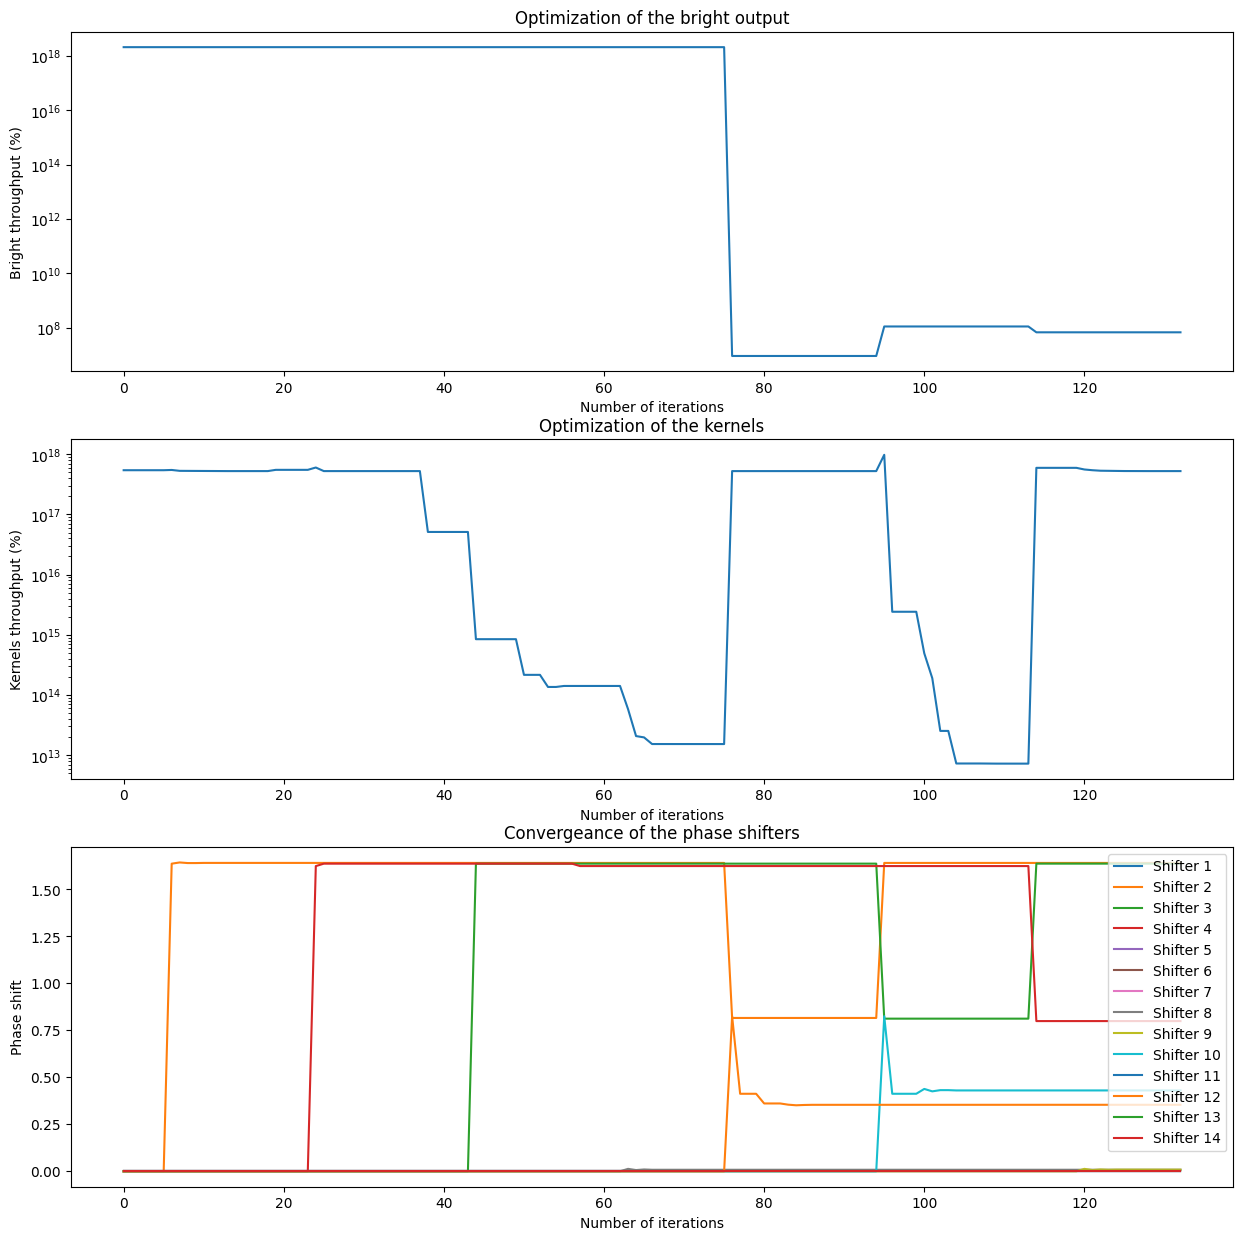

TypeError: plot_kn_phase_effect() got an unexpected keyword argument 'shifts'

In [26]:
def plot_optimization_history_ib():
    bright_evol, kernel_evol, shifts_evol = CALIBRATION_HISTORY_IB["bright"], CALIBRATION_HISTORY_IB["kernel"], CALIBRATION_HISTORY_IB["shifts"]

    _, axs = plt.subplots(3, 1, figsize=(15,15))

    axs[0].plot(bright_evol)
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel("Bright throughput (%)")
    axs[0].set_yscale("log")
    axs[0].set_title("Optimization of the bright output")

    axs[1].plot(kernel_evol)
    axs[1].set_xlabel("Number of iterations")
    axs[1].set_ylabel("Kernels throughput (%)")
    axs[1].set_yscale("log")
    axs[1].set_title("Optimization of the kernels")

    for i in range(shifts_evol.shape[1]):
        axs[2].plot(shifts_evol[:,i], label=f"Shifter {i+1}")
    axs[2].set_xlabel("Number of iterations")
    axs[2].set_ylabel("Phase shift")
    axs[2].set_yscale("linear")
    axs[2].set_title("Convergeance of the phase shifters")
    axs[2].legend(loc='upper right')

    plt.show()

plot_optimization_history_ib()
plot_kn_phase_effect(shifts=CALIBRATED_SHIFTS_IB)
plot_transmission_maps(shifts=CALIBRATED_SHIFTS_IB, shifts_total_opd=SHIFTS_TOTAL_OPD)

kn(STAR_SIGNALS, CALIBRATED_SHIFTS_IB, reference_flux=STAR_FLUX)

## 🧬 Genetic algorithm

### Algorithm

in order to get the best shifts to inject to optimize the component performances, I made a genetic algorithme that iteratively mutate a shifter and keep the mutation if it minimize the associated metric. All the shifters that act on the bright channel are associated with the bright metric that must be maximized

$$
M_B = |B|^2
$$

While the other shifters are associated with the kernel metric that must be minimized.

$$
M_K = |K_1|^2 + |K_2|^2 + |K_3|^2
$$

Merging these two metrics can induce local minimum since improving the bright metric can deterior the kernel metric. This separation is then necessary to ensure reaching a global minimum (empirically demonstrated)

> **Acknowledgment**
> - Romain Laugier for the idea of merging the metrics

In [ ]:
def calibrate(verbose: bool = False) -> tuple[u.Quantity, dict[str, np.ndarray[float]]]:
    """
    Optimize the phase shifters offsets to maximize the nulling performance

    Parameters
    ----------
    - kn: Kernel-Nuller object
    - beams: List of input beams complex amplitudes
    - verbose: Boolean, if True, print the optimization process

    Returns
    -------
    - Array of optimized phase shifters offsets
    - Dict containing the history of the optimization
    """

    shifts = np.zeros(14) * L.unit
    signals = get_input_fields(norm=STAR_FLUX, angular_separation=0*u.mas)

    treshold = 1e-6 * L.unit # Minimum shift step size
    decay = 1.01  # Decay factor for the step size (delta /= decay)

    # Shifters that contribute to redirecting light to the bright output
    # p1 = [2,3,4,5,7]
    p1 = [1, 2, 3, 4, 5, 7]
    # p1 = [2, 4, 7]
    # p1 = [2, 3, 4]

    # Shifters that contribute to the symmetry of the dark outputs
    # p2 = [6,8,11,13,14]
    p2 = [6, 8, 9, 10, 11, 12, 13, 14]
    # p2 = [8, 11, 13, 14]
    # p2 = [6, 9, 10, 12]

    # History of the optimization
    bright_history = []
    asymmetry_history = []
    metric_history = []
    shifters_history = []

    delta = L / 4
    while delta > treshold:

        if verbose:
            print(color.black(color.on_red(f"--- New iteration ---")), f"Delta={delta:.2e}")

        for p in p1 + p2:
            log = ""

            # Step vector
            step = np.zeros(14) * L.unit
            step[p - 1] = delta

            # Apply the step
            _, kernels_old, bright_old = kn(beams=signals, shifts=shifts)
            _, kernels_pos, bright_pos = kn(beams=signals, shifts=shifts + step)
            _, kernels_neg, bright_neg = kn(beams=signals, shifts=shifts - step)

            # Total Kernels relative intensity
            kernels_neg = np.sum(np.abs(kernels_neg)) / (STAR_FLUX * DT)
            kernels_old = np.sum(np.abs(kernels_old)) / (STAR_FLUX * DT)
            kernels_pos = np.sum(np.abs(kernels_pos)) / (STAR_FLUX * DT)

            # Birght relative intensity
            bright_neg /= STAR_FLUX * DT
            bright_old /= STAR_FLUX * DT
            bright_pos /= STAR_FLUX * DT

            metric_neg =  kernels_neg / bright_neg
            metric_old =  kernels_old / bright_old
            metric_pos =  kernels_pos / bright_pos

            # Save the history
            bright_history.append(bright_old)
            asymmetry_history.append(kernels_old)
            metric_history.append(metric_old)
            shifters_history.append(np.copy(shifts))

            metric = False

            if not metric:
                # Maximize the bright metric for group 1 shifters
                if p in p1:
                    log += "Shift " + color.black(color.on_lightgrey(f"{p}")) + " Bright: " + color.black(color.on_green(f"{bright_neg:.2e} | {bright_old:.2e} | {bright_pos:.2e}")) + " -> "

                    if bright_pos > bright_old and bright_pos > bright_neg:
                        log += color.black(color.on_green(" + "))
                        shifts += step
                    elif bright_neg > bright_old and bright_neg > bright_pos:
                        log += color.black(color.on_green(" - "))
                        shifts -= step
                    else:
                        log += color.black(color.on_green(" = "))

                # Minimize the asymmetry metric for group 2 shifters
                else:
                    log += "Shift " + color.black(color.on_lightgrey(f"{p}")) + " Asymmetry:  " + color.black(color.on_blue(f"{kernels_neg:.2e} | {kernels_old:.2e} | {kernels_pos:.2e}")) + " -> "

                    if kernels_pos < kernels_old and kernels_pos < kernels_neg:
                        shifts += step
                        log += color.black(color.on_blue(" + "))
                    elif kernels_neg < kernels_old and kernels_neg < kernels_pos:
                        shifts -= step
                        log += color.black(color.on_blue(" - "))
                    else:
                        log += color.black(color.on_blue(" = "))

            else: 
                log += "Shift " + color.black(color.on_lightgrey(f"{p}")) + " Metric:  " + color.black(color.on_purple(f"{metric_neg:.2e} | {metric_old:.2e} | {metric_pos:.2e}")) + " -> "

                if metric_pos < metric_old and metric_pos < metric_neg:
                    shifts += step
                    log += color.black(color.on_purple(" + "))
                elif metric_neg < metric_old and metric_neg < metric_pos:
                    shifts -= step
                    log += color.black(color.on_purple(" - "))
                else:
                    log += color.black(color.on_purple(" = "))
            
            if verbose:
                print(log)

        delta /= decay

    return bound_phase(shifts), {
        "bright": np.array(bright_history),
        "asymmetry": np.array(asymmetry_history),
        "shifters": np.array(shifters_history),
    }

CALIBRATED_SHIFTS, CALIBRATION_HISTORY = calibrate(verbose=False)

In [ ]:
def plot_optimization_history():
    bright_evol, dark_asymmetry_evol, shifts_evol = CALIBRATION_HISTORY["bright"], CALIBRATION_HISTORY["asymmetry"], CALIBRATION_HISTORY["shifters"]

    _, axs = plt.subplots(3,1, figsize=(15,15))

    axs[0].plot(bright_evol)
    axs[0].set_xlabel("Number of iterations")
    axs[0].set_ylabel("Bright throughput (%)")
    axs[0].set_yscale("log")
    axs[0].set_title("Optimization of the bright output")

    axs[1].plot(dark_asymmetry_evol)
    axs[1].set_xlabel("Number of iterations")
    axs[1].set_ylabel("Kernels throughput (%)")
    axs[1].set_yscale("log")
    axs[1].set_title("Optimization of the kernels")

    print(np.mean(dark_asymmetry_evol[-2000:]))

    for i in range(shifts_evol.shape[1]):
        axs[2].plot(shifts_evol[:,i], label=f"Shifter {i+1}")
    axs[2].set_xlabel("Number of iterations")
    axs[2].set_ylabel("Phase shift")
    axs[2].set_yscale("linear")
    axs[2].set_title("Convergeance of the phase shifters")
    axs[2].legend(loc='upper right')

    plt.show()

plot_optimization_history()
plot_kn_phase_effect(shifts=CALIBRATED_SHIFTS)
plot_transmission_maps(shifts=CALIBRATED_SHIFTS, shifts_total_opd=SHIFTS_TOTAL_OPD)

kn(STAR_SIGNALS, CALIBRATED_SHIFTS, reference_flux=STAR_FLUX)

### Reliability (WIP)

In [ ]:
def optimization_emprical_proof():

    _, axs = plt.subplots(2, 7, figsize=(20, 5))
    axs = axs.flatten()

    _, axs2 = plt.subplots(2, 7, figsize=(20, 5))
    axs2 = axs2.flatten()

    for _ in range(100):
        shifts_total_opd = np.array(np.random.uniform(0, L.value, 14)) * L.unit
        calibrated_shifts, _ = calibrate(shifts_total_opd=shifts_total_opd)

        E = bound_phase(shifts_total_opd)
        P = bound_phase(calibrated_shifts)

        for i in range(14):
            axs[i].scatter(E[i], P[i], color='blue', s=1)
            axs[i].set_xlabel("Introduced error")
            axs[i].set_ylabel("Optimized shift")
            axs[i].set_title(f"P{i+1}")

        def bound(p):
            return bound_phase(p)

        axs2[0].scatter(bound(E[0] - E[1]), bound(P[0] - P[1]), color='blue', s=1)
        axs2[0].set_title("P1-P2")
        axs2[1].scatter(bound(E[2] - E[3]), bound(P[2] - P[3]), color='blue', s=1)
        axs2[1].set_title("P3-P4")
        axs2[2].scatter(bound(E[4] - E[6]), bound(P[4] - P[6]), color='blue', s=1)
        axs2[2].set_title("P5 - P7")
        axs2[3].scatter(bound(E[5] - E[7]), bound(P[5] - P[7]), color='blue', s=1)
        axs2[3].set_title("P6 - P8")
        axs2[4].scatter(bound(E[8] - E[10]), bound(P[8] - P[10]), color='blue', s=1)
        axs2[4].set_title("P9 - P11")
        axs2[5].scatter(bound(E[9] - E[12]), bound(P[9] - P[12]), color='blue', s=1)
        axs2[5].set_title("P10 - P13")
        axs2[6].scatter(bound(E[11] - E[13]), bound(P[11] - P[13]), color='blue', s=1)
        axs2[6].set_title("P12 - P14")

        axs2[7].scatter(bound((E[0] + E[1]) - (E[2] + E[3])), bound((P[0] + P[1]) - (P[2] + P[3])), color='blue', s=1)
        axs2[7].set_title("(P1-P2)*P5 - (P3-P4)*P7")

        axs2[8].scatter((E[0] + E[1])/2 * E[4] - ((E[2] + E[3])/2 * E[6]), ((P[0] + P[1])/2 * P[4]) - ((P[2] + P[3])/2 * P[6]), color='blue', s=1)
        axs2[8].set_title("(P1+P2)/2*P5 - (P3+P4)/2*P7")

        for i in range(14):
            axs2[i].set_xlabel("Introduced error")
            axs2[i].set_ylabel("Optimized shift")

    plt.show()

# optimization_emprical_proof()

## 🤖 Machine Learning

Another approach to retrieve the correct shifts inject is to use machine learning techniques. There is several ways to do so. Here we will focus a supervised dense neural network. To do so, we will have to build a dataset.

As the solutions are degenerated, we will not ask the network to predict the best shift to inject, but we will ask it to predict the shfit aberrations instead. From these aberation, we are able to determine a solution for the shifts to inject.

As input of the network, we need to give enough information to caracterize the parameter space. The most straightforward approach would be to create a grid in the parameter space and give the kenrel outputs for each of the point in these grid.

Unfortunately, we work in a parameter space of 14 dimensions which is too large to be covered by a grid. A solution is to consider only the vectors that form the cardinal basis of this parameter space.

### Dataset generation

In [ ]:
def parameter_grid(N, D, a, b):
    """
    Generate a list of points forming a grid in a parameter space.

    Parameters
    ----------
    - N: Resolution of the grid (point per axes)
    - D: Dimension of the space parameter
    - a: Minimum value of the space parameter
    - b: Maximum value of the space parameter

    Returns
    -------
    - An array of vectors describing a point in the parameter space
    """
    return np.array([a + (b-a) * (((x // N**np.arange(D,dtype=float)) % N)/N) for x in range(N**D)])

In [ ]:
def parameter_basis(D, b=1):
    """
    Return the basis vectors of the parameter space (+ the null vector)

    Parameters
    ----------
    - D: Dimension of the space parameter
    - b: Norm of the basis vector (default=1)

    Returns
    -------
    - An array of vectors describing a point in the parameter space
    """

    vectors = np.zeros((D+1,D))
    for i in range(D):
        vectors[i+1,i] = b
    return vectors

In [ ]:
def parameter_basis_2p(D, b=1):
    """
    Return the basis vectors of the parameter space (+ the null vector)

    Parameters
    ----------
    - D: Dimension of the space parameter
    - b: Norm of the basis vector (default=1)

    Returns
    -------
    - An array of vectors describing a point in the parameter space
    """

    vectors = np.zeros((2*D+1,D))
    for i in range(D):
        vectors[2*i+1,i] = b
        vectors[2*i+2,i] = 2*b
    return vectors

In [ ]:
def get_dataset(size=1000):
    # grid_points = parameter_grid(2, 14, 0, 1.65)
    # grid_points = parameter_basis(14, 1.65/2)
    grid_points = parameter_basis_2p(14, 1.65/3)
    vector_len = len(grid_points)*7 + 14
    dataset = np.empty((size, vector_len))

    for v in range(size):

        shifts_total_opd = np.random.uniform(0, 1, 14) * L/10
        vector = np.empty(vector_len)

        for p, point in enumerate(grid_points):
            _, darks, bright = kn_fields_njit(beams=STAR_SIGNALS, shifts=point, shifts_total_opd=shifts_total_opd)

            vector[p*7:p*7+6] = np.abs(darks)**2
            vector[p*7+6] = np.abs(bright)**2

        vector[-14:] = shifts_total_opd
        dataset[v] = vector

    return dataset

DATASET = get_dataset(10_000)
print(DATASET.shape)

In [ ]:
def get_random_dataset(size=1000):

    nb_points = 100

    i_len = (7+14)
    o_len = 14

    vector_len = nb_points*i_len + o_len
    dataset = np.empty((size, vector_len))

    pv=0
    for v in range(size):

        if (nv := v*100//size) > pv:
            print(nv, "%", end='\r')
            pv = nv

        shifts_total_opd = np.random.uniform(0, 1, 14) * L/10
        vector = np.empty(vector_len)

        for p in range(nb_points):
            shifts = np.random.uniform(0, L.value, size=14)
            _, darks, bright = kn_fields_njit(beams=STAR_SIGNALS, shifts=shifts, shifts_total_opd=shifts_total_opd)

            vector[p*i_len:(p+1)*i_len] = np.concatenate([shifts, np.abs(darks)**2, [np.abs(bright)**2]])

        vector[-14:] = shifts_total_opd
        dataset[v] = vector

    return dataset

# DATASET = get_random_dataset(10_000)
# print(DATASET.shape)

In [ ]:
DATASET[:,-14:].shape

### Model definition (WIP)

In [ ]:
def get_model(input_shape):
    i = tf.keras.Input(shape=(input_shape,), name='Input')
    # x = tf.keras.layers.Normalization(axis=None, mean=np.mean(DATASET[:,:-14]), variance=np.std(DATASET[:,:-14]), invert=False, name="Normalization")(i)
    x = tf.keras.layers.Dense(128, activation='relu', name='Dense_1')(i)
    x = tf.keras.layers.Dense(64, activation='relu', name='Dense_2')(x)
    x = tf.keras.layers.Dense(32, activation='relu', name='Dense_3')(x)
    o = tf.keras.layers.Dense(14, activation='relu', name='Output')(x)
    # o = tf.keras.layers.Normalization(axis=None, mean=np.mean(DATASET[:,-14:]), variance=np.std(DATASET[:,-14:]), invert=True, name="Denormalization")(x)
    return tf.keras.Model(inputs=i, outputs=o)

MODEL = get_model(input_shape=DATASET.shape[1]-14)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
MODEL.compile(optimizer=optimizer, loss='mse')
MODEL.summary()

### Model training

In [ ]:
def train_model():
    X = DATASET[:, :-14]
    Y = DATASET[:, -14:]

    print(DATASET.shape, X.shape, Y.shape)

    return MODEL.fit(X, Y, epochs=10, batch_size=5, validation_split=0.2, )

history = train_model()

In [ ]:
plt.plot(history.history['loss'], label='loss') 
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
TEST_SET = get_dataset(size=10)
X = TEST_SET[:, :-14]
Y = TEST_SET[:, -14:]

PREDICTIONS = MODEL.predict(X)
print(X)
print(PREDICTIONS)

# print(Y)
# print(PREDICTIONS)

cpt = 0
for i in range(10):
    for j in range(len(Y[i])):
        # print(f"Shifter {j}: E = {Y[i][j]:.2f}", f"P = {PREDICTIONS[i][j]:.2f}")
        plt.scatter(Y[i][j], PREDICTIONS[i][j])
        cpt += 1
    #     if cpt > 1:break
    # if cpt > 1:break

plt.xlabel("Expectations")
plt.ylabel("Preditions")
plt.show()

In [ ]:
# TEST_SET = get_random_dataset(size=10)
# X = TEST_SET[:, :-14]
# Y = TEST_SET[:, -14:]

# PREDICTIONS = MODEL.predict(X)
# print(X)
# print(PREDICTIONS)

# # print(Y)
# # print(PREDICTIONS)

# cpt = 0
# for i in range(10):
#     for j in range(len(Y[i])):
#         # print(f"Shifter {j}: E = {Y[i][j]:.2f}", f"P = {PREDICTIONS[i][j]:.2f}")
#         plt.scatter(Y[i][j], PREDICTIONS[i][j])
#         cpt += 1
#     #     if cpt > 1:break
#     # if cpt > 1:break

# plt.xlabel("Expectations")
# plt.ylabel("Preditions")
# plt.show()

## 🎭 Shifters correlation

In [ ]:
def scan(
    scan_on,
    restricted: bool = False,
):
    """
    Scan the parameter space and plot the null depths for each parameter
    combination.

    Parameters
    ----------
    - kn: An instance of the KernelNuller class.
    - beams: A list of 2D arrays, each representing a beam.
    - optimized_parameters: A list of 14 floats, the optimized parameters.

    Returns
    -------
    - None
    """

    # Scan shift power parameter space
    scan = np.linspace(0, L.value, 101, endpoint=True) * L.unit

    # Initialize the maps
    nulls_map = np.zeros((3, len(scan), len(scan)))
    darks_map = np.zeros((6, len(scan), len(scan)))
    kernels_map = np.zeros((3, len(scan), len(scan)))
    bright_map = np.zeros((len(scan), len(scan)))

    # Create the figure
    _, axs = plt.subplots(3, 5, figsize=(30, 15))

    # Consider only errors & correction on the shifter that are being scanned
    if restricted:
        shifts = np.zeros(14) * L.unit
        shifts_total_opd = np.zeros(14) * L.unit
        shifts_total_opd[scan_on[0] - 1] = SHIFTS_TOTAL_OPD[scan_on[0] - 1]
        shifts_total_opd[scan_on[1] - 1] = SHIFTS_TOTAL_OPD[scan_on[1] - 1]

    # Consider all shifter errors & corrections
    else:
        shifts = CALIBRATED_SHIFTS.copy()
        shifts_total_opd = SHIFTS_TOTAL_OPD.copy()

    signals = get_input_fields(angular_separation=0*u.mas)

    for i, scan1 in enumerate(scan):
        for j, scan2 in enumerate(scan):
            shifts[scan_on[0] - 1] = scan1
            shifts[scan_on[1] - 1] = scan2

            nulls, darks, bright = kn_fields(beams=signals, shifts=shifts, shifts_total_opd=shifts_total_opd)
            
            kernels = np.array([
                    np.abs(darks[2*i])**2 - np.abs(darks[2*i+1])**2
                for i in range(3)])

            for k, null in enumerate(nulls):
                nulls_map[k, i, j] = np.abs(null)**2
            for k, dark in enumerate(darks):
                darks_map[k, i, j] = np.abs(dark)**2
            for k, kernel in enumerate(kernels):
                kernels_map[k, i, j] = kernel
            bright_map[i, j] = np.abs(bright)**2

    for k in range(3):
        p = axs[k, 0]
        p.set_title(f"Null {k+1}")
        im = p.imshow(
            nulls_map[k],
            extent=[0, L.value, 0, L.value],
            vmin=np.min(nulls_map),
            vmax=np.max(nulls_map),
        )
        p.scatter(
            CALIBRATED_SHIFTS[scan_on[1] - 1],
            CALIBRATED_SHIFTS[scan_on[0] - 1],
            color="red",
            edgecolors="white",
            s=100,
        )
        p.scatter(
            IDEAL_SHIFTS[scan_on[1] - 1],
            IDEAL_SHIFTS[scan_on[0] - 1],
            color="green",
            edgecolors="white",
            s=100,
        )
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    for k in range(6):
        p = axs[k // 2, k % 2 + 1]
        p.set_title(f"Dark {k+1}")
        im = p.imshow(
            darks_map[k],
            extent=[0, L.value, 0, L.value],
            vmin=np.min(darks_map),
            vmax=np.max(darks_map),
            cmap="hot",
        )
        p.scatter(
            CALIBRATED_SHIFTS[scan_on[1] - 1],
            CALIBRATED_SHIFTS[scan_on[0] - 1],
            color="red",
            edgecolors="white",
            s=100,
        )
        p.scatter(
            IDEAL_SHIFTS[scan_on[1] - 1],
            IDEAL_SHIFTS[scan_on[0] - 1],
            color="green",
            edgecolors="white",
            s=100,
        )
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    for k in range(3):
        p = axs[k, 3]
        p.set_title(f"Kernel {k+1}")
        im = p.imshow(
            kernels_map[k],
            extent=[0, L.value, 0, L.value],
            vmin=np.min(kernels_map),
            vmax=np.max(kernels_map),
            cmap="bwr",
        )
        p.scatter(
            CALIBRATED_SHIFTS[scan_on[1] - 1],
            CALIBRATED_SHIFTS[scan_on[0] - 1],
            color="red",
            edgecolors="white",
            s=100,
        )
        p.scatter(
            IDEAL_SHIFTS[scan_on[1] - 1],
            IDEAL_SHIFTS[scan_on[0] - 1],
            color="green",
            edgecolors="white",
            s=100,
        )
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    p = axs[1, 4]
    p.set_title(f"Bright")
    im = p.imshow(bright_map, extent=[0, L.value, 0, L.value], cmap="gray")
    p.scatter(
        CALIBRATED_SHIFTS[scan_on[1] - 1],
        CALIBRATED_SHIFTS[scan_on[0] - 1],
        color="red",
        edgecolors="white",
        s=100,
    )
    p.scatter(
        IDEAL_SHIFTS[scan_on[1] - 1],
        IDEAL_SHIFTS[scan_on[0] - 1],
        color="green",
        edgecolors="white",
        s=100,
    )
    p.set_xlabel(f"Parameter {scan_on[1]}")
    p.set_ylabel(f"Parameter {scan_on[0]}")
    plt.colorbar(im)

    axs[0, 4].axis("off")
    axs[2, 4].axis("off")

    plt.show()

scan_on = (1, 2)
scan(scan_on=scan_on, restricted=True)
scan(scan_on=scan_on, restricted=False)

---

<div align=center>

# ⚙️ **Data generation**

</div>

## 🟨 Single observation

In [ ]:
@nb.njit()
def generate_one_distrib_njit(
    N: int = 1000,  # Number of observations
    star_signals: np.array = STAR_SIGNALS,  # Star signals
    planet_signals: np.array = PLANET_SIGNALS,  # Planet signals
    shifts: np.array = CALIBRATED_SHIFTS.to(L.unit).value,  # Shifts to apply
    shifts_total_opd: np.array = SHIFTS_TOTAL_OPD.to(L.unit).value,  # Shifts error
    input_ce_rms: float = INPUT_CE_RMS.to(L.unit).value,  # Input OPD RMS
    wavelength: float = L.value,  # Wavelength
):
    """
    Simulate several observation of the Kernel-Nuller in the same conditions.

    Parameters
    ----------
    - N: Number of observations
    - star_signals: Star signals
    - planet_signals: Planet signals
    - shifts: Shifts to apply
    - shifts_total_opd: Shifts error
    - input_ce_rms: Input OPD RMS
    - wavelength: Wavelength

    Returns
    -------
    - Darks outputs without planet (6 x N)
    - Darks outputs with planet (6 x N)
    - Kernels outputs without planet (3 x N)
    - Kernels outputs with planet (3 x N)
    """

    darks_dist_so = np.empty((6, N))
    darks_dist_wp = np.empty((6, N))
    kernels_dist_so = np.empty((3, N))
    kernels_dist_wp = np.empty((3, N))

    for i in range(N):

        noise = np.random.normal(0, input_ce_rms, 4)

        noised_star_signals = phase_shift_njit(star_signals, noise, wavelength)
        noised_planet_signals = phase_shift_njit(planet_signals, noise, wavelength)

        darks_so, kernels_so, _ = kn_njit(noised_star_signals, shifts, shifts_total_opd, wavelength)
        darks_wp, kernels_wp, _ = kn_njit(noised_planet_signals, shifts, shifts_total_opd, wavelength)

        darks_dist_so[:, i] = darks_so
        darks_dist_wp[:, i] = darks_wp + darks_so
        kernels_dist_so[:, i] = kernels_so
        kernels_dist_wp[:, i] = kernels_wp + kernels_so

    return (
        darks_dist_so,
        darks_dist_wp,
        kernels_dist_so,
        kernels_dist_wp,
    )

# User-friendly interface (Numba can't manage dicts with unconsistent data)
def generate_one_distrib(
    N: int = 1000,
    star_signals: np.ndarray[complex] = STAR_SIGNALS,
    planet_signals: np.ndarray[complex] = PLANET_SIGNALS,
    shifts: u.Quantity = CALIBRATED_SHIFTS,
    shifts_total_opd: u.Quantity = SHIFTS_TOTAL_OPD,
    input_ce_rms: u.Quantity = INPUT_CE_RMS,
    wavelength: u.Quantity = L,
):
    """
    Simulate several observation of the Kernel-Nuller in the same conditions.

    Parameters
    ----------
    - N: Number of observations
    - star_signals: Star signals
    - planet_signals: Planet signals
    - shifts: Shifts to apply
    - shifts_total_opd: Shifts error
    - input_ce_rms: Input OPD RMS
    - wavelength: Wavelength

    Returns
    -------
    - Dictionary containing:
        - "darks_so" dark outpus with star only (6 x N)
        - "darks_wp" dark outpus with star and planet (6 x N)
        - "kernels_so" kernel outpus with star only (3 x N) (with photon noise)
        - "kernels_wp" kernel outpus with star and planet (3 x N) (with photon noise)
    """

    outputs = generate_one_distrib_njit(
        N,
        star_signals,
        planet_signals,
        shifts.to(wavelength.unit).value,
        shifts_total_opd.to(wavelength.unit).value,
        input_ce_rms.to(wavelength.unit).value,
        wavelength.value,
    )
    return {
        "darks_so": outputs[0],
        "darks_wp": outputs[1],
        "kernels_so": outputs[2],
        "kernels_wp": outputs[3],
    }

IDEAL_DISTS = generate_one_distrib(
    shifts=np.zeros(14)*L.unit,
    shifts_total_opd=np.zeros(14)*L.unit
)

CALIBRATED_DISTS = generate_one_distrib()

PERTURBED_DISTS = generate_one_distrib(
    shifts=np.zeros(14)*L.unit
)

## 🟡 Parallactic diversity

In [ ]:
def generate_hour_diversity_data(h_range=H_RANGE):
    """
    Generate the data for the hour diversity study.

    Parameters
    ----------
    - h_range: Range of hour angles

    Returns
    -------
    - Array of data for each kernel (3 x len(h_range))
    """

    data = np.zeros((3, len(h_range)))
    for i, h in enumerate(h_range):

        dists = generate_one_distrib()

        for k in range(3):
            data[k, i] = np.median(dists['kernels_wp'][k])

    return data

HOUR_DIVERSITY_DATA = generate_hour_diversity_data()

---

<div align=center>

# 🔎 **Data analysis**

</div>

## 📊 Output distributions

In [ ]:
def plot_distributions(calibrated_dists=CALIBRATED_DISTS, ideal_dists=IDEAL_DISTS, perturbed_dists=PERTURBED_DISTS):

    null_outputs = ['N3b', 'N4a', 'N4b']

    bins = 300

    # Dark ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    fig, axs = plt.subplots(6, 1, figsize=(15, 30))
    for i in range(6):
        ax = axs[i]

        ax.hist(calibrated_dists['darks_so'][i], bins=bins, color='red', label=f"Star only (calibrated)", alpha=0.5, log=True)
        ax.hist(calibrated_dists['darks_wp'][i], bins=bins, color='blue', label=f"With planet (calibrated)", alpha=0.5, log=True)
        ax.hist(ideal_dists['darks_so'][i], bins=bins, histtype='step', color='red', label=f"Star only (ideal)", linewidth=1, log=True)
        ax.hist(ideal_dists['darks_wp'][i], bins=bins, histtype='step', color='blue', label=f"With planet (ideal)", linewidth=1, log=True)
        if perturbed_dists is not None:
            ax.hist(perturbed_dists['darks_so'][i], bins=bins, histtype='step', color='orange', linestyle="dashed", label=f"Star only (perturbed)", linewidth=1, log=True)
            ax.hist(perturbed_dists['darks_wp'][i], bins=bins, histtype='step', color='purple', linestyle="dashed", label=f"With planet (perturbed)", linewidth=1, log=True)

        ax.set_xlabel("Intensity (photons)")
        ax.set_ylabel("Number of occurences")
        ax.set_title(f"Dark {i+1}")
        ax.legend()

    # Kernel ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        ax = axs[i]

        ax.hist(calibrated_dists['kernels_so'][i], bins=bins, color='red', label=f"Star only (ideal)", density=True, alpha=0.5, log=True)
        ax.hist(calibrated_dists['kernels_wp'][i], bins=bins, color='blue', label=f"With planet (ideal)", density=True, alpha=0.5, log=True)
        ax.hist(ideal_dists['kernels_so'][i], bins=bins, histtype='step', color='red', label=f"Star only (real)", linewidth=1, density=True, log=True)
        ax.hist(ideal_dists['kernels_wp'][i], bins=bins, histtype='step', color='blue', label=f"With planet (real)", linewidth=1, density=True, log=True)
        if perturbed_dists is not None:
            ax.hist(perturbed_dists['kernels_so'][i], bins=bins, histtype='step', color='black', linestyle="dashed", label=f"Star only (perturbed)", linewidth=1, density=True, log=True)
            ax.hist(perturbed_dists['kernels_wp'][i], bins=bins, histtype='step', color='purple', linestyle="dashed", label=f"With planet (perturbed)", linewidth=1, density=True, log=True)

        ax.set_xlabel("Intensity (photons)")
        ax.set_ylabel("Number of occurences")
        ax.set_title(f"Theoretical Kernel {i+1} (perfect cameras)")
        ax.legend()       

    plt.show()

plot_distributions()

## 📢 Noise sensitivity

In [ ]:
def plot_sensitivity_to_noise(shifts=CALIBRATED_SHIFTS, shifts_total_opd=SHIFTS_TOTAL_OPD):

    input_ce_rms_range, step = np.linspace(0, 3*SHIFTS_CE_RMS.to(u.nm).value, 25, retstep=True)
    input_ce_rms_range *= u.nm
    step *= u.nm
    stds = []

    _, ax = plt.subplots(1, 1, figsize=(15, 5))

    for i, input_ce_rms in enumerate(input_ce_rms_range):

        dists_perturbated = generate_one_distrib(1000, STAR_SIGNALS, np.zeros(4, dtype=np.complex128)*L.unit, np.zeros(14)*L.unit, shifts_total_opd, input_ce_rms, L)
        dists_calibrated = generate_one_distrib(1000, STAR_SIGNALS, np.zeros(4, dtype=np.complex128)*L.unit, shifts, shifts_total_opd, input_ce_rms, L)
        dists_ideal = generate_one_distrib(1000, STAR_SIGNALS, np.zeros(4, dtype=np.complex128)*L.unit, np.zeros(14)*L.unit, np.zeros(14)*L.unit, input_ce_rms, L)

        kernel_dist_perturbated = np.concatenate([*dists_perturbated['kernels_so']])
        kernel_dist_calibrated = np.concatenate([*dists_calibrated['kernels_so']])
        kernel_dist_ideal = np.concatenate([*dists_ideal['kernels_so']])

        kernel_dist_perturbated = dists_perturbated['kernels_so'][0]
        kernel_dist_calibrated = dists_calibrated['kernels_so'][0]
        kernel_dist_ideal = dists_ideal['kernels_so'][0]

        stds.append(np.std(kernel_dist_perturbated))
        stds.append(np.std(kernel_dist_calibrated))
        stds.append(np.std(kernel_dist_ideal))

        ax.scatter(np.random.normal(input_ce_rms.value - step.value/5, step.value/20, len(kernel_dist_perturbated)), kernel_dist_perturbated, color='tab:red', s=5 if i == 0 else 0.1, alpha=1 if i==0 else 1, label="Perturbated" if i == 0 else None)
        ax.scatter(np.random.normal(input_ce_rms.value, step.value/20, len(kernel_dist_calibrated)), kernel_dist_calibrated, color='tab:green', s=5 if i == 0 else 0.1, alpha=1 if i==0 else 1, label="Calibrated" if i == 0 else None)
        ax.scatter(np.random.normal(input_ce_rms.value + step.value/5, step.value/20, len(kernel_dist_ideal)), kernel_dist_ideal, color='tab:blue', s=5 if i == 0 else 0.1, alpha=1 if i==0 else 1, label="Ideal" if i == 0 else None)
        
        ax.boxplot(kernel_dist_perturbated, vert=True, positions=[input_ce_rms.value - step.value/5],widths=step.value/5, showfliers=False, manage_ticks=False)
        ax.boxplot(kernel_dist_calibrated, vert=True, positions=[input_ce_rms.value],widths=step.value/5, showfliers=False, manage_ticks=False)
        ax.boxplot(kernel_dist_ideal, vert=True, positions=[input_ce_rms.value + step.value/5],widths=step.value/5, showfliers=False, manage_ticks=False)

    ax.set_ylim(-max(stds), max(stds))
    ax.set_xlabel(f"Input OPD RMS ({input_ce_rms_range.unit})")
    ax.set_ylabel("Kernel intensity (photons)")
    ax.set_title("Sensitivity to noise")
    ax.legend()

plot_sensitivity_to_noise()

## ☑️ Model fitting (WIP)

Distributions are cool, but in order to make deeper analysis, we want to find a model that describe these distribution using few parameters. Unfortunately, there is no straightforward way to get such model as these distribution are very particular.

The next block try most of the common distribution models and show the best ones... but unfortunately, none of them seems to match 😞

In [ ]:
def fit(data):
    f = fitter.Fitter(data,
           distributions=fitter.get_distributions())
    f.fit()
    f.summary()

# fit(IDEAL_DISTS['kernels_so'][0])

## 📈 Test statistics

A test statistic is a way of reducing the data we have to an unique number and compare this number to a threshold value. If the number is below the treshold, then the null hypothesis is favored. If it is above, the alternative hypothesis is favored. The goal is to find the best test statistic that allow to distinguish both hypothesis in a correct way

- $H0$: the null hypothesis -> there is no planet
- $H1$: the alternative hypothesis -> there is a planet

- $T0$: vector of distributions obtained with H0
- $T1$: vector of distributions obtained with H1

In [ ]:
@nb.njit()
def get_distrib_vectors(Nmc, size):
    T0 = np.zeros((3, Nmc,size))
    T1 = np.zeros((3, Nmc,size))
    for i in range(Nmc):
        dists = generate_one_distrib_njit(size)
        for k in range(3):
            T0[k,i] = dists[2][k]
            T1[k,i] = dists[3][k]
    return T0, T1

T0, T1 = get_distrib_vectors(1000, 1000)

### Mean

**Principle:** We take the average of the distribution and we compare it to a treshold.

$$
\left|\frac{1}{N}\sum_i x_i \right| \stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

In [ ]:
def ts_mean(data):
    return np.abs(np.mean(data, axis=1))

### Median

**Principle:** We take the median of the distribution and we compare it to a treshold.

$$
\begin{cases}
\left| x_{\frac{N+1}{2}} \right| & \text{if }N\text{ is odd} \\

\left| \frac{x_{\frac{N}{2}} + x_{\frac{N+1}{2}}}{2} \right|  & \text{if }N\text{ is odd}
\end{cases}
\quad\stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

In [ ]:
def ts_median(data):
    return np.abs(np.median(data, axis=1))

### Argmax

**Principle:** We pack our data in bins and we consider the position of the bin with the highest number of occurences. We compare it to a treshold.

In [ ]:
def ts_argmax(data, bins=100):
    maxs = np.zeros(data.shape[0])
    for i, dist in enumerate(data):
        hist = np.histogram(dist, bins=bins)
        maxs[i] = hist[1][np.argmax(hist[0])]
    return np.abs(maxs)

def ts_argmax50(data):
    return ts_argmax(data, 50)

def ts_argmax100(data):
    return ts_argmax(data, 100)

def ts_argmax500(data):
    return ts_argmax(data, 500)

### Kolmogorov-Smirnov

**Principle:** We compare the maximum distance on the cumulative distribution functions of the two distributions.

In [ ]:
def ts_kolmogorov_smirnov(data):

    distances = np.zeros(data.shape[0])

    for d, dist in enumerate(data):

        ref_dist = CALIBRATED_DISTS['kernels_so'][0]

        dist = np.sort(dist)
        ref_dist = np.sort(ref_dist)

        v = np.min(np.concatenate([dist, ref_dist]))

        i_ref = 0
        i_dist = 0

        count_ref = 0
        count_dist = 0

        while i_ref < len(ref_dist) and i_dist < len(dist):

            if ref_dist[i_ref] < dist[i_dist]:
                count_ref += 1
                i_ref += 1
            else:
                count_dist += 1
                i_dist += 1
            
            distances[d] = max(distances[d], np.abs(count_dist - count_ref) )#/ len(reference))

    return distances

### Cramèr-von Mises

**Principle:** We compare the total quadratique distance on the cumulative distribution functions of the two distributions.

In [ ]:
def ts_cramer_von_mises(data):

    distances = np.zeros(data.shape[0])

    for d, dist in enumerate(data):

        ref_dist = CALIBRATED_DISTS['kernels_so'][0]

        dist = np.sort(dist)
        ref_dist = np.sort(ref_dist)

        v = np.min(np.concatenate([dist, ref_dist]))

        i_ref = 0
        i_dist = 0

        count_ref = 0
        count_dist = 0

        while i_ref < len(ref_dist) and i_dist < len(dist):

            if ref_dist[i_ref] < dist[i_dist]:
                count_ref += 1
                i_ref += 1
            else:
                count_dist += 1
                i_dist += 1
            
            distances[d] += np.abs(count_dist - count_ref) ** 2

    return distances


### Wilcoxon-Mann-Whitney (WIP)

In [ ]:
def ts_wilcoxon_mann_whitney(data):

    res = np.empty(len(data))

    ref_dist = CALIBRATED_DISTS['kernels_so'][0]

    for d, dist in enumerate(data):

        sorted_comb = np.unique(np.sort(np.concatenate([dist, ref_dist])))

        r1 = np.sum(np.searchsorted(sorted_comb, dist) + 1)
        r2 = np.sum(np.searchsorted(sorted_comb, ref_dist) + 1)

        n1 = len(dist)
        n2 = len(ref_dist)

        u1 = n1*n2 + n1*(n1+1)/2 - r1
        u2 = n1*n2 + n2*(n2+1)/2 - r2

        res[d] = min(u1, u2)
    
    return res

### CDF diff area (Aurélie's idea)

In [ ]:
def ts_cdf_diff_area(data):
    """
    Compute the area between the 2 CDF 
    """
    #data
    num_simulations = data.shape[0]
    distances = np.zeros(num_simulations)
    
    ref_dist = CALIBRATED_DISTS['kernels_so'][0]
    ref_dist_sorted = np.sort(ref_dist)
    m = len(ref_dist_sorted)
    cdf_ref_dist = np.arange(1, m + 1) / m

    for d in range(num_simulations):
        dist = data[d, :]
        dist = np.sort(dist)
        n = len(dist)
        cdf_dist = np.arange(1, n + 1) / n

        #interpolation 
        cdf_ref_dist_interp = np.interp(dist, ref_dist_sorted, cdf_ref_dist)

        #test 
        cdf_diff = cdf_dist - cdf_ref_dist_interp
        area = np.trapz(cdf_diff, dist)
        distances[d] = area
    
    return distances

In [ ]:
TEST_STATISTICS = {
    'Mean': ts_mean,
    'Median': ts_median,
    # 'argmax50': ts_argmax50,
    # 'argmax100': ts_argmax100,
    'Argmax500': ts_argmax500,
    'Kolmogorov-Smirnov': ts_kolmogorov_smirnov,
    'Cramer Von Mises': ts_cramer_von_mises,
    'Wilcoxon Mann Whitney': ts_wilcoxon_mann_whitney,
    'CDF Diff. Area': ts_cdf_diff_area
}

## ❓ ROC curves

ROC curves allow to compare the power of different test statistics. It show the proportion of true detection in function of the probability of false alarm. The more the curve climb fast, the better it is.

In [ ]:
def roc(T0, T1, test_statistic, multiple_source=False):

    N = len(T0)

    # Computing test statistic of all the distributions
    if not multiple_source: 
        T0_values = test_statistic(T0)
        T1_values = test_statistic(T1)
    else:
        T0_values = np.zeros(T0.shape[1])
        T1_values = np.zeros(T0.shape[1])
        for i in range(len(T0)):
            T0_values += test_statistic(T0[i])
            T1_values += test_statistic(T1[i])

    # Computng the maximum treshold value
    sup = np.max(np.concatenate([T0_values, T1_values]))

    thresholds = np.linspace(0, sup, 1000)
    
    Pfa = np.zeros(len(thresholds))
    Pdet = np.zeros(len(thresholds))
    for i, threshold in enumerate(thresholds):
        Pfa[i] = np.sum(T0_values > threshold) / N
        Pdet[i] = np.sum(T1_values > threshold) / N

    return Pfa, Pdet, thresholds

In [ ]:
def plot_roc(test_statistics = TEST_STATISTICS):

    _, axs = plt.subplots(1, 4, figsize=(25, 5))

    for k in range(4):
        for ts_name, ts in test_statistics.items():
            if k < 3:
                Pfa, Pdet, _ = roc(T0[k], T1[k], ts)
                axs[k].set_title(f"Kernel {k+1}")
            else:
                Pfa, Pdet, _ = roc(T0, T1, ts, multiple_source=True)
                axs[k].set_title(f"All kernels")
            axs[k].plot(Pfa, Pdet, label=ts_name)
            axs[k].set_xlabel("Pfa")
            axs[k].set_ylabel("Pdet")
            axs[k].legend()

    plt.suptitle(f"ROC curves - C={CONTRAST:.1e}, Aberration RMS={INPUT_CE_RMS:.2e}")
    plt.show()

plot_roc()

## 💪 P-values

The P-value is an indicator of the confidence we have to reject the null hypothesis.

The principle consist in comparing the test statistic obtain on the data we want to test with a large bunch of data that we know to be under the null hypothesis. We then compute the proportion of test statistic that are above the one we obtained. This proportion is the P-value.

Thus, the lower the P-value, the more confident we are to reject the null hypothesis. A P-value below 0.05 is commonly considered as a good indicator to reject the null hypothesis.

In [ ]:
def plot_p_values(test_statistics = TEST_STATISTICS):

    col = min(2, len(test_statistics))
    row = int(np.ceil(len(test_statistics) / col))

    _, axs = plt.subplots(row, col, figsize=(5*col, 5*row))
    axs = axs.flatten()
    
    t = 0
    for ts_name, ts in test_statistics.items():
        cumulated_values = np.zeros(T0.shape[1])
        sup = 0
        for k in range(4):
            if k < 3:
                values = ts(T0[k])
                cumulated_values += values / 3
                label = f"Kernel {k+1}"
            elif k == 3:
                values = cumulated_values
                label = "Cumulated"
            sup = max(sup, np.max(values))
            thresholds = np.linspace(0, sup, 1000)
            p_values = np.zeros(len(thresholds))
            for i, threshold in enumerate(thresholds):
                p_values[i] = np.sum(values > threshold) / len(values)
            axs[t].plot(thresholds, p_values, label=label)
        axs[t].hlines(0.05, 0, sup, color='red', linestyle='dashed')
        axs[t].set_xlabel("Threshold")
        axs[t].set_ylabel("P-value")
        axs[t].set_title(f"P-values for {ts_name}")
        axs[t].legend()
        t+=1
    plt.show()

plot_p_values()

---

<div align=center>

# 🪐 **Characterization**

</div>

## 🔄️ Angular diversity

In order to determine the planet position, we need to rotate the interferometer baseline in order to rotate the transmission map. Thus, the planet signal will be modulated. By analysis this modulation (trying to fit the parametrized modulation function to the data points), it is possible to retrieve the planet position.

In [ ]:
@nb.njit()
def kernels_modulation_njit(
    h_range:np.ndarray[float]=H_RANGE.to(u.rad).value,
    alpha:float=PARALLACTIC_ANGLE.to(u.rad).value,
    theta:float=ANGULAR_SEPARATION.to(u.rad).value,
    # contrast:float=CONTRAST
) -> np.ndarray[float]:
    """
    Compute the modulation of the kernels with respect to the hour angle

    Parameters
    ----------
    - h_range: The range of hour angles to consider (in radian)
    - alpha: Parallactic angle (in radian)
    - theta: Angular separation (in radian)
    - contrast: The contrast value

    Returns
    -------
    - The modulation of the kernels.
    """

    kernels_mod = np.zeros((3, len(h_range)))
    for h, dh in enumerate(h_range):

        projected_telescope_position = project_position_njit(h=dh)

        signals = get_input_fields_njit(
            norm=PLANET_FLUX,
            projected_telescope_positions=projected_telescope_position,
            parallactic_angle=alpha,
            angular_separation=theta,
        )

        _, kernels, _ = kn_njit(
            signals,
            shifts=np.zeros(14),
            shifts_total_opd=np.zeros(14),
        )

        for i in range(3):
            kernels_mod[i, h] = kernels[i] * CONTRAST * OPTICAL_EFFICIENCY

    return kernels_mod

def kernels_modulation(
    h_range:u.Quantity=H_RANGE,
    alpha:u.Quantity=PARALLACTIC_ANGLE,
    theta:u.Quantity=ANGULAR_SEPARATION,
    # contrast:float=CONTRAST
):
    return kernels_modulation_njit(h_range.to(u.rad).value, alpha.to(u.rad).value, theta.to(u.rad).value) # , contrast)

kernel_modulation = [lambda h,a,t: kernels_modulation(h,a,t)[i] for i in range(3)]
kernel_modulation_njit = [lambda h,a,t: kernels_modulation_njit(h,a,t)[i] for i in range(3)]

In [ ]:
def iplot_kernels_modulation():
    alpha_slider = widgets.FloatSlider(value=PARALLACTIC_ANGLE.value, min=0, max=2*np.pi, step=2*np.pi/1000, description=f'Alpha (rad)')
    theta_slider = widgets.FloatSlider(value=ANGULAR_SEPARATION.value, min=0, max=FOV.value, step=FOV.value/1000, description=f'Theta ({FOV.unit})')
    contrast_slider = widgets.FloatSlider(value=int(np.log10(CONTRAST)), min=-10, max=0, step=1, description=f'Contrast')
    plot = widgets.Image()
    reset = widgets.Button(description="Reset")

    def update_plot(*args):
        kms = kernels_modulation(H_RANGE, alpha_slider.value*u.rad, (theta_slider.value*FOV.unit).to(u.rad)) # , 10**contrast_slider.value

        fig, axs = plt.subplots(1, 3, figsize=(20, 3))

        for i in range(3):
            ax = axs[i]
            ax.plot(H_RANGE, kms[i])
            ax.set_title(f"Kernel {i+1}")
            ax.set_xlabel("Hour angle (rad)")
            ax.set_ylabel("Intensity")  

        buffer = BytesIO()
        plt.savefig(buffer, format='png')
        plot.value = buffer.getvalue()
        plt.close()

    def reset_values(*args):
        alpha_slider.value = PARALLACTIC_ANGLE.value
        theta_slider.value = ANGULAR_SEPARATION.value
        contrast_slider.value = int(np.log10(CONTRAST))

    alpha_slider.observe(update_plot)
    theta_slider.observe(update_plot)
    contrast_slider.observe(update_plot)
    reset.on_click(reset_values)

    update_plot()
    display(widgets.VBox([alpha_slider, theta_slider, contrast_slider, plot, reset]))

iplot_kernels_modulation()

In [ ]:
def plot_hour_diversity(
        data=HOUR_DIVERSITY_DATA,
        h_range=H_RANGE,
    ):

    fits = np.zeros((3, len(h_range)))

    print("Param    = Ideal | First guess | Found")
    print("======================================")

    popts = []
    for i in range(3):
        # Fit data to kernels modulations
        p0 = [PARALLACTIC_ANGLE.value + np.random.normal(0,0.1*np.pi), (ANGULAR_SEPARATION + np.random.normal(0,0.2)*u.mas).to(u.rad).value] # , CONTRAST * np.random.normal(1,0.1)

        popt, pcov = curve_fit(
            kernel_modulation_njit[i],
            h_range.value,
            data[i],
            p0=p0,
            maxfev=10000
        )

        print(f"Alpha    = {PARALLACTIC_ANGLE.to(u.deg):.2f} | {(p0[0]*u.rad).to(u.deg):.2f} | {(popt[0]*u.rad).to(u.deg):.2f}")
        print(f"Theta    = {ANGULAR_SEPARATION.to(u.mas):.2f} | {(p0[1]*u.rad).to(u.mas):.2f} | {(popt[1]*u.rad).to(u.mas):.2f}")
        # print(f"Contrast = {CONTRAST:.2e} | {p0[2]:.2e} | {popt[2]:.2e}")
        print("---")
        popts.append(popt)
    popt = np.mean(popts, axis=0)

    _, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        fits[i] = kernels_modulation_njit(h_range.to(u.rad).value, *popt)[i]

        ax = axs[i]

        ax.scatter(h_range, data[i], label="Data",alpha=0.5)
        ax.plot(h_range, kernels_modulation_njit(h_range.to(u.rad).value)[i], "--", label="Expected signal")
        ax.plot(h_range, kernels_modulation_njit(h_range.to(u.rad).value, *popts[i])[i], label="Specific fit")
        ax.plot(h_range, fits[i], label="Global fit")

        ax.set_xlabel("Observation time (hour)")
        ax.set_ylabel("Kernel intensity")
        ax.set_title(f"Kernel {i+1}")
        ax.legend()

    plt.show()

    print("Param    = Ideal | Found")
    print("========================")
    print(f"Alpha    = {PARALLACTIC_ANGLE.to(u.deg):.2f} | {(popt[0]*u.rad).to(u.deg):.2f}")
    print(f"Theta    = {ANGULAR_SEPARATION.to(u.mas):.2f} | {(popt[1]*u.rad).to(u.mas):.2f}")
    # print(f"Contrast = {CONTRAST:.2e} | {popt[2]:.2e}")

plot_hour_diversity()

## 🌌 On-sky contribution

From the obtained data, it is possible to build a 2D distribution of the perceived sky contribution zones. This distribution provides insights into the possible locations of objects, enabling accurate initial estimations to fit the data points obtained based on the parallactic angle.

This method involves stacking the transmission maps rotated by the baseline rotation and weighting each map by the corresponding data obtained for that baseline rotation.

The base idea was already explored as "image reconstruction" technic using classical nulling interferometry $^1$. However, the method here is based on Kernel-Nulls which makes it more complex but less sensitive to phase aberations and by considerig the different Kernels, we can reduce the degeneracy of the solutions.

Considering:
- $T_{n}$ represents the n-th kernel's normalized transmission map.
- $d_{n,\beta}$ denotes the data point obtained for kernel $n$ with baseline rotation $\beta$.
- $\alpha$ is the parallactic angle.
- $\theta$ is the angular separation.

$$
r_n(\theta, \alpha) = \sum_a T_{n,h}(\theta,\alpha) d_{n,h}
$$


As the kernel outputs are antisymetric, we can filter the negative contributions:
$$
r'_n = \frac{1}{2}(r_n+|r_n|)
$$


Finally, we can compute the product over all the kernels to get the final contribution zones:
$$
C(\theta, \alpha) = \prod_n r'_n(\theta, \alpha)
$$

**References:**
1. Angel, J. R. P., et N. J. Woolf. "An Imaging Nulling Interferometer to Study Extrasolar Planets". *The Astrophysical Journal* 475, no 1 (1997): 373‑79. https://doi.org/10.1086/303529.

In [ ]:
def plot_contribution_zones(
    data: np.ndarray[float] = HOUR_DIVERSITY_DATA,
    fov: u.Quantity = FOV,
    resolution: int = 100,
):

    images = np.zeros((3, resolution, resolution))
    integrated_kernels = np.zeros((3, resolution, resolution))

    _, _, theta_map, _ = get_uv_map(resolution=resolution, fov=fov)
    _, _, kernel_maps = get_transmission_map(resolution=resolution)
    theta_map = theta_map.value / np.max(theta_map.value)

    for i, h in enumerate(H_RANGE):

        for j in range(3):
            projected_telescope_position = project_position(h=h)
            tm = get_transmission_map(projected_telescope_positions=projected_telescope_position)[2][j]
            integrated_kernels[j] += np.abs(tm) #* theta_map
            images[j] += tm * data[j, i] #* theta_map

    for i in range(3):
        integrated_kernel_intensity = np.sum(integrated_kernels[i])
        kernel_intensity = np.sum(np.abs(kernel_maps[i]))

        normalization_factor = integrated_kernel_intensity / kernel_intensity

        print(f"Kernel {i+1} : {integrated_kernel_intensity:.2e} / {kernel_intensity:.2e} = {normalization_factor:.2e}")

        images[i] /= normalization_factor

    max_im = np.max(images)

    _, axs = plt.subplots(1, 4, figsize=(25, 5))

    planet_x, planet_y = αθ_to_xy()

    for i in range(3):
        img = images[i]
        img[img < 0] = 0
        im = axs[i].imshow(img, cmap="hot", vmax=max_im, extent=EXTENT)
        axs[i].set_title(f"Kernel {i+1}")
        plt.colorbar(im, ax=axs[i])
        axs[i].scatter(planet_x, planet_y, marker="+", color="white")

    # Take mean of probable input flux
    img = np.mean(images, axis=0)

    # Filter where a probability of flux is null on one of the kernels
    images[images < 0] = 0
    mask = np.prod(images, axis=0)
    img = img * mask / np.max(mask)

    # Plot reconstructed image
    im = axs[3].imshow(img, cmap="hot", extent=EXTENT)
    axs[3].set_title("Contribution zones")
    plt.colorbar(im, ax=axs[3])
    axs[3].scatter(planet_x, planet_y, marker="+", color="white")

    plt.show()

plot_contribution_zones()

## ♒ Correlation map (WIP)

In [ ]:
def correlation_map(
        data=HOUR_DIVERSITY_DATA,
        h_range=H_RANGE,
    ):

    resolution = 20
    
    _, _, alpha_map, theta_map = get_uv_map(resolution=resolution)

    correl_map = np.zeros((resolution, resolution))

    for x in range(resolution):
        for y in range(resolution):

            alpha = alpha_map[x, y]
            theta = theta_map[x, y]

            km = kernels_modulation(h_range, alpha=alpha, theta=theta)[0]

            correl_map[x, y] = np.sum(np.corrcoef(data[0], km))


    _, ax = plt.subplots(1, 1, figsize=(15, 15))
    im = ax.imshow(correl_map)
    plt.colorbar(im, ax=ax)
    ax.set_title("Correlation map")

    plt.show()

correlation_map()